# Initialization

### Hyper-parameters (variables)

In [1]:
TAU = 200  # LCA time constant.
EPOCHS = 1  # periods of training.

STRIDE = 2  # LCA convolutional stride.
LAMBDA = 2  # neuron activation threshold.

FEATURES = 140  # number of dictionary features to learn.
LCA_ITERS = 1000  # number of LCA timesteps per forward pass.

NUM_INPUT_REP = 3600  # total amount of samples for the experiment.
BATCH_SIZE = 60  # number of samples for each windowed batch split.
PERC = 1/10   # input samples percentage to train for a single run.

PRINT_FREQS = 1  # calculations print frequency with modulus operandi.

WINDOW_SIZE = 7  # number of datapoints for each windowed input sample.
KERNEL_SIZE = 9  # Kernel value of the dimensions for convolutional features.

SPLITTED_BATCHES = int(NUM_INPUT_REP // BATCH_SIZE * PERC)
SPLITTED_BATCHES

6

### Dependencies

In [3]:
import glob
import math
import os
import time

from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv1D, LCAConv2D, LCAConv3D
from lcapt.metric import compute_l1_sparsity, compute_l2_error
from lcapt.preproc import make_unit_var, make_zero_mean

import torch

from torchvision.utils import make_grid, save_image

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from dython.nominal import associations
from jupyterplot import ProgressPlot
from PIL import Image

import imageio as iio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

2022-10-16 00:21:52.131846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 00:21:52.660743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-16 00:21:52.660777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-16 00:21:52.735528: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-16 00:21:54.117528: W tensorflow/stream_executor/platform/de

### Model Initialization

In [4]:
# if needed, select cuda device
# torch.cuda.set_device(2)

lca = LCAConv3D(
    140,
    1,
    "linked_testing",
    9,
    9,
    7,
    2,
    2,
    1,
    2,  # lca_thresh = lambda
    no_time_pad=True,
    lca_iters=1000,
    return_all=False,
).cuda()

with torch.no_grad():
    ckpt = torch.load("../models/lca_imagenet_vid_dict.pth")
    lca.assign_weight_values(ckpt.module.weights)

lca = torch.nn.DataParallel(lca)
lca.n_cells = 100

# Linked Data

### Video

In [5]:
# grab movie's frames that are repeated to all mice
movie = BrainObservatoryCache().get_ophys_experiment_data(501940850).get_stimulus_template("natural_movie_three")

# create empty tensor for the sliding frames with stride of specific length (number of rolling-window frames/sample)
torch_wf = torch.empty(size=(NUM_INPUT_REP - WINDOW_SIZE + 1, WINDOW_SIZE, movie.shape[-2], movie.shape[-1]))

for ind, im in enumerate(movie):
    if len(movie[ind : ind + WINDOW_SIZE]) == WINDOW_SIZE:
        torch_wf[ind] = torch.tensor(movie[ind : ind + WINDOW_SIZE])

print(f"number of total batches from {BATCH_SIZE} samples/batch: ", len(torch.split(torch_wf, BATCH_SIZE, 0)))
print("final, yet incomplete batch of", torch.split(torch_wf, BATCH_SIZE, 0)[-1].shape)
# tensor split equally into arbitrary sets of batches (samples/batch)
splitted_wf = torch.split(torch_wf, BATCH_SIZE, 0)

number of total batches from 60 samples/batch:  60
final, yet incomplete batch of torch.Size([54, 7, 304, 608])


### Traces

##### Read dataset and simple split

In [6]:
exps_cells = []
column_exp = []
column_cell = []
complete_column_cell_exp_list = []

# IMPORTANT: DO NOT UPLOAD dff.h5 TO REPO IF DEV
dff_df = pd.read_hdf("../data/V1 Responses/dff.h5")

# respectively slice by column cell and experiment
for column in dff_df.columns[7:]:
    complete_column_cell_exp_list.append(column)
    column_cell.append(column.split("_")[0])
    column_exp.append(column.split("_")[1])

# unique experiment IDs
new_column_exp = np.unique(column_exp)

print("Average cell count per experiment:")
print(
    len(np.unique(column_cell)) // len(np.unique(column_exp)),
    "=",
    len(np.unique(column_cell)),
    "//",
    len(np.unique(column_exp)),
)

# filter by experiment index
for exp_index in range(15, 22):
    for cell_exp in complete_column_cell_exp_list:
        if str(cell_exp).endswith(new_column_exp[exp_index]):
            exps_cells.append(cell_exp)

# print('total cells:', len(exps_cells))

Average cell count per experiment:
247 = 12380 // 50


##### dataframe filter and tensor split
###### averaging from all repetitions on the same experiment
###### *TIME CONSUMING*: ~3min from +1000 cells' experiments filtered to +500 with valid stimulus or ~15min for +3000 filtered to +1500

In [7]:
%%time

max_dff = pd.DataFrame()
mean_dff = pd.DataFrame()
max_dff_exps_movie3_list = []
mean_dff_exps_movie3_list = []

# filter previous experiment IDs with movie3 stimulus
dff_exps = dff_df[["frame", "stimulus", *exps_cells]]

for exp_cell_counter, exp_cell in enumerate(exps_cells):
    if dff_exps[dff_exps["stimulus"] == "natural_movie_three"][exp_cell].values.all() == False:
        max_dff_exps_movie3_list.append(
            torch.max(
                torch.stack(
                    list(
                        torch.split(
                            torch.tensor(
                                dff_exps[["stimulus", exp_cell]]
                                .where(dff_exps["stimulus"] == "natural_movie_three")
                                .dropna()[exp_cell]
                                .values
                            ),
                            NUM_INPUT_REP,
                            0,
                        )
                    )
                ),
                dim=0,
            ).values
        )
        mean_dff_exps_movie3_list.append(
            torch.mean(
                torch.stack(
                    list(
                        torch.split(
                            torch.tensor(
                                dff_exps[["stimulus", exp_cell]]
                                .where(dff_exps["stimulus"] == "natural_movie_three")
                                .dropna()[exp_cell]
                                .values
                            ),
                            NUM_INPUT_REP,
                            0,
                        )
                    )
                ),
                dim=0,
            )
        )
# create empty tensor for the sliding trace responses with stride of specific length (number of rolling-window traces/sample)
mean_torch_wt = torch.empty(size=(len(mean_dff_exps_movie3_list), NUM_INPUT_REP - WINDOW_SIZE + 1, WINDOW_SIZE)).cuda()
max_torch_wt = torch.empty(size=(len(max_dff_exps_movie3_list), NUM_INPUT_REP - WINDOW_SIZE + 1, WINDOW_SIZE)).cuda()

for trace_ind in range(len(max_dff_exps_movie3_list)):
    max_torch_wt[trace_ind] = torch.from_numpy(
        np.lib.stride_tricks.sliding_window_view(
            max_dff_exps_movie3_list[trace_ind].cpu().numpy(), window_shape=WINDOW_SIZE
        )
    )
    mean_torch_wt[trace_ind] = torch.from_numpy(
        np.lib.stride_tricks.sliding_window_view(
            mean_dff_exps_movie3_list[trace_ind].cpu().numpy(), window_shape=WINDOW_SIZE
        )
    )

# tensor split equally into arbitrary sets of batches (samples/batch)
splitted_wt = torch.split(torch.moveaxis(mean_torch_wt, 1, 0), BATCH_SIZE, 0)
print(
    max_torch_wt.shape,
    max_torch_wt[trace_ind].shape,
    mean_torch_wt.shape,
    mean_torch_wt[trace_ind].shape,
    splitted_wt[-1].shape,
    len(splitted_wt),
)

<timed exec>:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_numpy.cpp:178.)


torch.Size([511, 3594, 7]) torch.Size([3594, 7]) torch.Size([511, 3594, 7]) torch.Size([3594, 7]) torch.Size([54, 511, 7]) 60
CPU times: user 35min 46s, sys: 2min 34s, total: 38min 20s
Wall time: 3min


# LCA Training 

In [14]:
# create tensors to save outputs with shape of respective (per training batch):
# LCA states, sparse activations, video reconstructions, trace reconstructions
t_recons_time = torch.zeros((SPLITTED_BATCHES, BATCH_SIZE, lca.module.n_cells, WINDOW_SIZE), device="cpu")
recons_time = torch.zeros((SPLITTED_BATCHES, BATCH_SIZE, WINDOW_SIZE, torch_wf.shape[-2], torch_wf.shape[-1]), device="cpu")
trace_act_usage = torch.zeros((int(NUM_INPUT_REP * PERC), lca.module.trace_weights.shape[0], torch_wf.shape[-1] // 4, torch_wf.shape[-2]), device="cpu")
lca_neuron_states = torch.zeros((int(NUM_INPUT_REP * PERC), lca.module.trace_weights.shape[0], torch_wf.shape[-1] // 4, torch_wf.shape[-2]), device="cpu")

In [15]:
print("lca_neuron_states shape: ", lca_neuron_states.shape)
print("trace_act_usage shape: ", trace_act_usage.shape)
print("trace_recons shape: ", t_recons_time.shape)
print("recons shape: ", recons_time.shape)

lca_neuron_states shape:  torch.Size([360, 140, 152, 304])
trace_act_usage shape:  torch.Size([360, 140, 152, 304])
trace_recons shape:  torch.Size([6, 60, 100, 7])
recons shape:  torch.Size([6, 60, 7, 304, 608])


In [10]:
%matplotlib inline

pp = ProgressPlot(
    plot_names=["sparsity", "trace recon error", "Batch MSE Loss", "Final Sample MSE"],
    y_lim=[[1000, 100000000], [0, 500], [0, 1], [0, 1]],
    x_lim=[0, SPLITTED_BATCHES],
)

for ind, (windowed_frames_batch, windowed_traces_batch) in enumerate(zip(
    splitted_wf[int(NUM_INPUT_REP // BATCH_SIZE * PERC) + SPLITTED_BATCHES : int(NUM_INPUT_REP // BATCH_SIZE * PERC) + (SPLITTED_BATCHES * 2)],
    splitted_wt[int(NUM_INPUT_REP // BATCH_SIZE * PERC) + SPLITTED_BATCHES : int(NUM_INPUT_REP // BATCH_SIZE * PERC) + (SPLITTED_BATCHES * 2)]
)):
    windowed_frames_batch = torch.unsqueeze(windowed_frames_batch, 1)
    windowed_frames_batch = make_unit_var(make_zero_mean(windowed_frames_batch.cuda()))
    windowed_traces_batch = make_unit_var(make_zero_mean(windowed_traces_batch[:, :100].cuda()))

    acts, states = lca((windowed_frames_batch, windowed_traces_batch))
    recons, t_recons = lca.module.compute_recon(acts, lca.module.weights, True)
    lca.module.update_weights(acts, windowed_frames_batch - recons, windowed_traces_batch - t_recons, ind)

    for i, (act, state, recon, t_recon) in enumerate(zip(
        acts, states, recons, t_recons
    )):
        for j, (feature_act, feature_state) in enumerate(zip(act, state)):
            trace_act_usage[BATCH_SIZE * ind + i, j] = feature_act.squeeze(0).cpu()
            lca_neuron_states[BATCH_SIZE * ind + i, j] = feature_state.squeeze(0).cpu()
            if i == len(acts) - 1 and j == len(act) - 1:
                print(f"{feature_act.count_nonzero()} nonzero activations at\
                        batch index (ind) {ind}, sample index (i) {i + 1}, feature ind (j) {j + 1}")

    torch.save(
        lca_neuron_states[ind * BATCH_SIZE : (ind * BATCH_SIZE) + BATCH_SIZE],
        f"../data/traces_states/lca_chckpnt_{ind + (SPLITTED_BATCHES * 2)}.pt",
    )
    torch.save(
        trace_act_usage[ind * BATCH_SIZE : (ind * BATCH_SIZE) + BATCH_SIZE],
        f"../data/traces_act_usage/lca_chckpnt_{ind + (SPLITTED_BATCHES * 2)}.pt",
    )

    MSE_LOSS = torch.nn.functional.mse_loss(windowed_traces_batch[-1], t_recons[-1])
    batchs_MSE_LOSS = torch.nn.functional.mse_loss(windowed_traces_batch, t_recons)
    l2_trace_recon_error = compute_l2_error(windowed_traces_batch, t_recons).item()
    l2_recon_error = compute_l2_error(windowed_frames_batch, recons).item()
    l1_sparsity = compute_l1_sparsity(acts, lca.module.lambda_).item()
    total_energy = l2_recon_error + l1_sparsity + l2_trace_recon_error
    # if ind % PRINT_FREQ == 0:
    # print(f'L2 Trace Recon Error: {round(l2_trace_recon_error, 2)};',
    #         f'L2 Recon Error: {round(l2_recon_error, 2)};',
    #         f'Total Energy: {round(total_energy, 2)};',
    #         f'L1 Sparsity: {round(l1_sparsity, 2)};')



    # recons_sample = recon.squeeze().squeeze().cpu().numpy()
    # trace_recon_samples = trace_recon.squeeze().squeeze().cpu().numpy()
    # recon_error_samples = recon_error.squeeze().squeeze().cpu().numpy()

    # if ind == 1:
    # fig1, axs1 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
    # fig2, axs2 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
    # fig3, axs3 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
    # for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
    #     inputs_sample = recon_error_samples[a_ind] + recon_sample[a_ind]

    #     recons_sample = (recons_sample - recons_sample.min()) / (recons_sample.max() - recons_sample.min())
    #     inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())
    #     recon_error_sample = (recon_error_sample - recon_error_sample.min()) / (
    #         recon_error_sample.max() - recon_error_sample.min()
    #     )

    #     img1 = a1.imshow(inputs_sample, cmap="gray")
    #     img2 = a2.imshow(recons_sample, cmap="gray")
    #     img3 = a3.imshow(recons_error_sample, cmap="gray")

    #     a1.set_title(f"Input frame{a_ind+1}")
    #     a2.set_title(f"Recon frame{a_ind+1}")
    #     a3.set_title(f"Recon Error frame{a_ind+1}")

    pp.update([[l1_sparsity], [l2_trace_recon_error], [batchs_MSE_LOSS], [MSE_LOSS]])

torch.save(lca, f"../models/testLinkDict.pth")
pp.finalize()
plt.close()

nonzero activations: 358                        at batch index 0 (ind), sample index 60 (i), feature ind 140 (j)
nonzero activations: 85                        at batch index 1 (ind), sample index 60 (i), feature ind 140 (j)
nonzero activations: 1                        at batch index 2 (ind), sample index 60 (i), feature ind 140 (j)
nonzero activations: 0                        at batch index 3 (ind), sample index 60 (i), feature ind 140 (j)
nonzero activations: 0                        at batch index 4 (ind), sample index 60 (i), feature ind 140 (j)
nonzero activations: 0                        at batch index 5 (ind), sample index 60 (i), feature ind 140 (j)


In [ ]:
MSE_LOSS = torch.nn.functional.mse_loss(windowed_traces_batch[-1], t_recons[-1])
batchs_MSE_LOSS = torch.nn.functional.mse_loss(windowed_traces_batch, t_recons)

# Visualizations

### Pre-trained LCA Vis

In [ ]:
# %matplotlib inline
# # ONLY if loading from pre-trained model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# pretrain_lca = torch.load('../models/plotVidFixLinkDict.pth', map_location=device)

# windowed_frames_batch = torch.unsqueeze(splitted_wf[100], 1).to(device)
# windowed_traces_batch = splitted_wt[100][:, :100].to(device)

# code = pretrain_lca((windowed_frames_batch, windowed_traces_batch))
# recon, trace_recon = pretrain_lca.module.compute_recon(code, pretrain_lca.module.weights, True)

# pretrain_lca.module.update_weights(code, windowed_frames_batch - recon, windowed_traces_batch - trace_recon, len(splitted_wt))
# fig1, axs1 = plt.subplots(1, WINDOW_SIZE, figsize=(16,9))
# fig2, axs2 = plt.subplots(1, WINDOW_SIZE, figsize=(16,9))
# fig3, axs3 = plt.subplots(1, WINDOW_SIZE, figsize=(16,9))
# for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
#     trace_recon_error = windowed_traces_batch - trace_recon
#     trace_recon_samples = trace_recon[0].squeeze().squeeze().cpu().numpy()

#     recon_error = windowed_frames_batch - recon
#     recon_samples = recon[0].squeeze().squeeze().cpu().numpy()
#     recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()


#     recon_sample = recon_samples[a_ind]
#     recon_error_sample = recon_error_samples[a_ind]
#     inputs_sample = (recon_error_sample + recon_sample)

#     recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
#     inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

#     img1 = a1.imshow(inputs_sample, cmap='gray')
#     img2 = a2.imshow(recon_sample, cmap='gray')
#     img3 = a3.imshow(recon_error_sample, cmap='gray')

#     a1.set_title(f'Input frame{a_ind+1}')
#     a2.set_title(f'Recon frame{a_ind+1}')
#     a3.set_title(f'Recon Error frame{a_ind+1}')
# plt.show()
# plt.close()

In [ ]:
# T = pretrain_lca.module.weights.shape[2]
# grids = []
# for t in range(T):
#     grids.append(make_grid(pretrain_lca.module.weights[:, :, t],
#                            int(math.sqrt(pretrain_lca.module.weights.shape[0])),
#                            normalize=False, scale_each=False, pad_value=0.5).cpu())
# final_grids = torch.stack(grids).permute(0, 2, 3, 1)
# iio.mimwrite(f"../reports/plotVidFixLinkDict.gif", final_grids.cpu().numpy(), "gif")
# exp_weight_grid = make_feature_grid(pretrain_lca.module.trace_weights[:, 0].squeeze(-1).moveaxis(1, -1))
# weight_grid = make_feature_grid(pretrain_lca.module.trace_weights.squeeze(-1).squeeze(-1))
# # arrange by neuron activation frequency (maximum to minimum)
# for i in range(exp_weight_grid.shape[0] % PRINT_FREQ + 10):
#     plt.plot(exp_weight_grid[i].cpu().numpy())
#     # plt.plot(weight_grid[i].cpu().numpy())
#     plt.grid()
#     plt.show()
#     plt.close()

In [ ]:
# for i in range(len(trace_recon_error)):

#     plt.close()
#     fig, axs = plt.subplots(1, 2, figsize=(30, 20))

#     axs[0].plot((trace_recon_error[i, 0] + trace_recon[i, 0]).cpu().numpy(), linewidth=2, label = 'input')
#     axs[0].plot(trace_recon.cpu().numpy()[i, 0], c='r', linewidth=2, label = 'reconstruction')

#     axs[1].plot(trace_recon_error[i, 0].cpu().numpy(), c='g')

#     axs[0].set_title('Trace Input and Reconstruction')
#     axs[1].set_title('Trace Reconstruction Error')
#     axs[0].legend(loc='upper right')
#     plt.axis('tight')
#     axs[1].grid()
#     axs[0].grid()
#     plt.show()

### Video Reconstruction

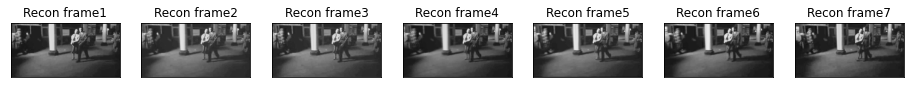

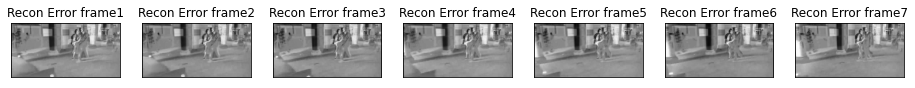

In [ ]:
fig1, axs1 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
fig2, axs2 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
fig3, axs3 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
for ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
    recon_error = windowed_frames_batch - recon

    recon_samples = recon[0].squeeze().squeeze().cpu().numpy()

    recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()

    recon_sample = recon_samples[ind]
    recon_error_sample = recon_error_samples[ind]
    inputs_sample = recon_error_sample + recon_sample

    recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
    inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

    img1 = a1.imshow(inputs_sample, cmap="gray")
    img2 = a2.imshow(recon_sample, cmap="gray")
    img3 = a3.imshow(recon_error_sample, cmap="gray")

    a1.set_title(f"Input frame{ind+1}")
    a2.set_title(f"Recon frame{ind+1}")
    a3.set_title(f"Recon Error frame{ind+1}")

    a1.get_xaxis().set_visible(False)
    a1.get_yaxis().set_visible(False)
    a2.get_xaxis().set_visible(False)
    a2.get_yaxis().set_visible(False)
    a3.get_xaxis().set_visible(False)
    a3.get_yaxis().set_visible(False)
plt.show()

### Activation Histogram

torch.Size([60, 140, 1, 152, 304]) 
 torch.Size([140, 100, 7, 1, 1]) 
 (140,) 
 [324 318 320 316 315 343 354 340 334 318 330 338 247 305 323 299 325 318
 342 313 334 307 374 320 348 328 329 321 340 310 238 318 326 346 202 325
 303 335 315 321 317 314 288 333 300 317 315 308 330 330 288 309 356 295
 374 333 306 348 314 344 298 346 286 292 314 305 322 315 346 269 208 347
 325 360 355 315 290 299 307 326 338 299 321 304 343 320 299 300 341 330
 332 324 271 345 341 261 310 361 320 341 337 310 356 318 320 317 322 311
 309 302 313 325 321 315 307 299 308 316 330 343 317 261 340 334 324 333
 334 315 325 333 322 329 336 351 312 299 319 310 322 326] 
 (140,) 
 2772480
(140, 2) 0.9266526719759927 0.0


/home/gonz495/miniconda3/envs/lca/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:title={'center':'average sparsity: 0.45538775510204077'}, xlabel='feature'>

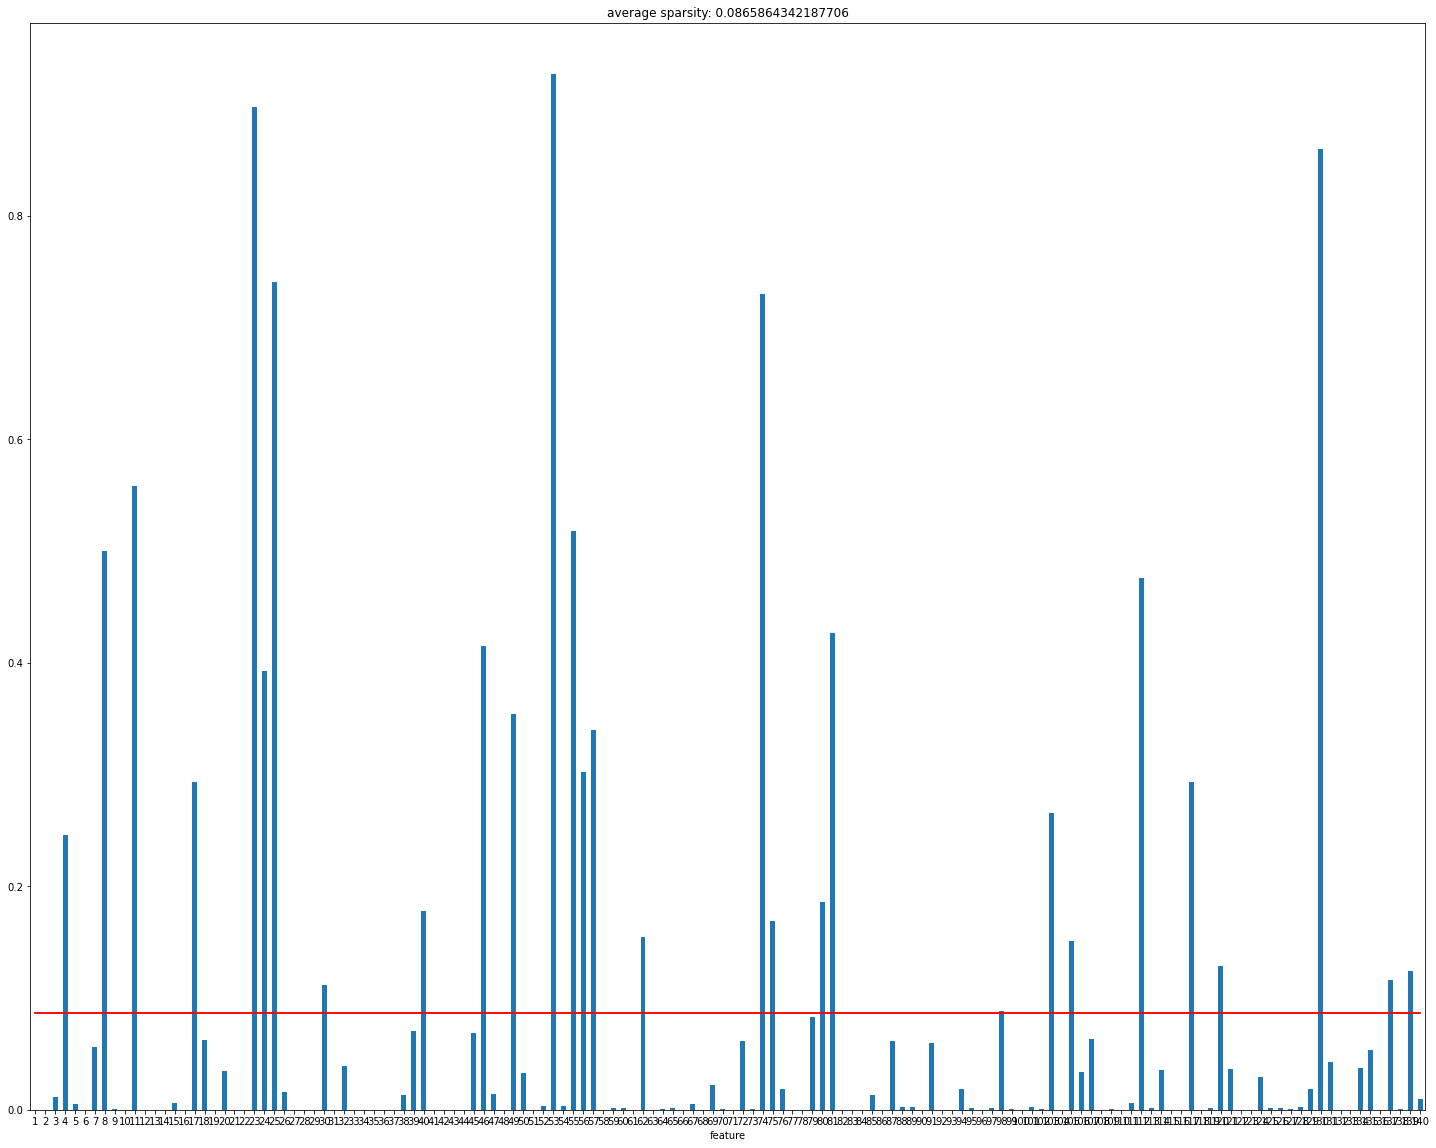

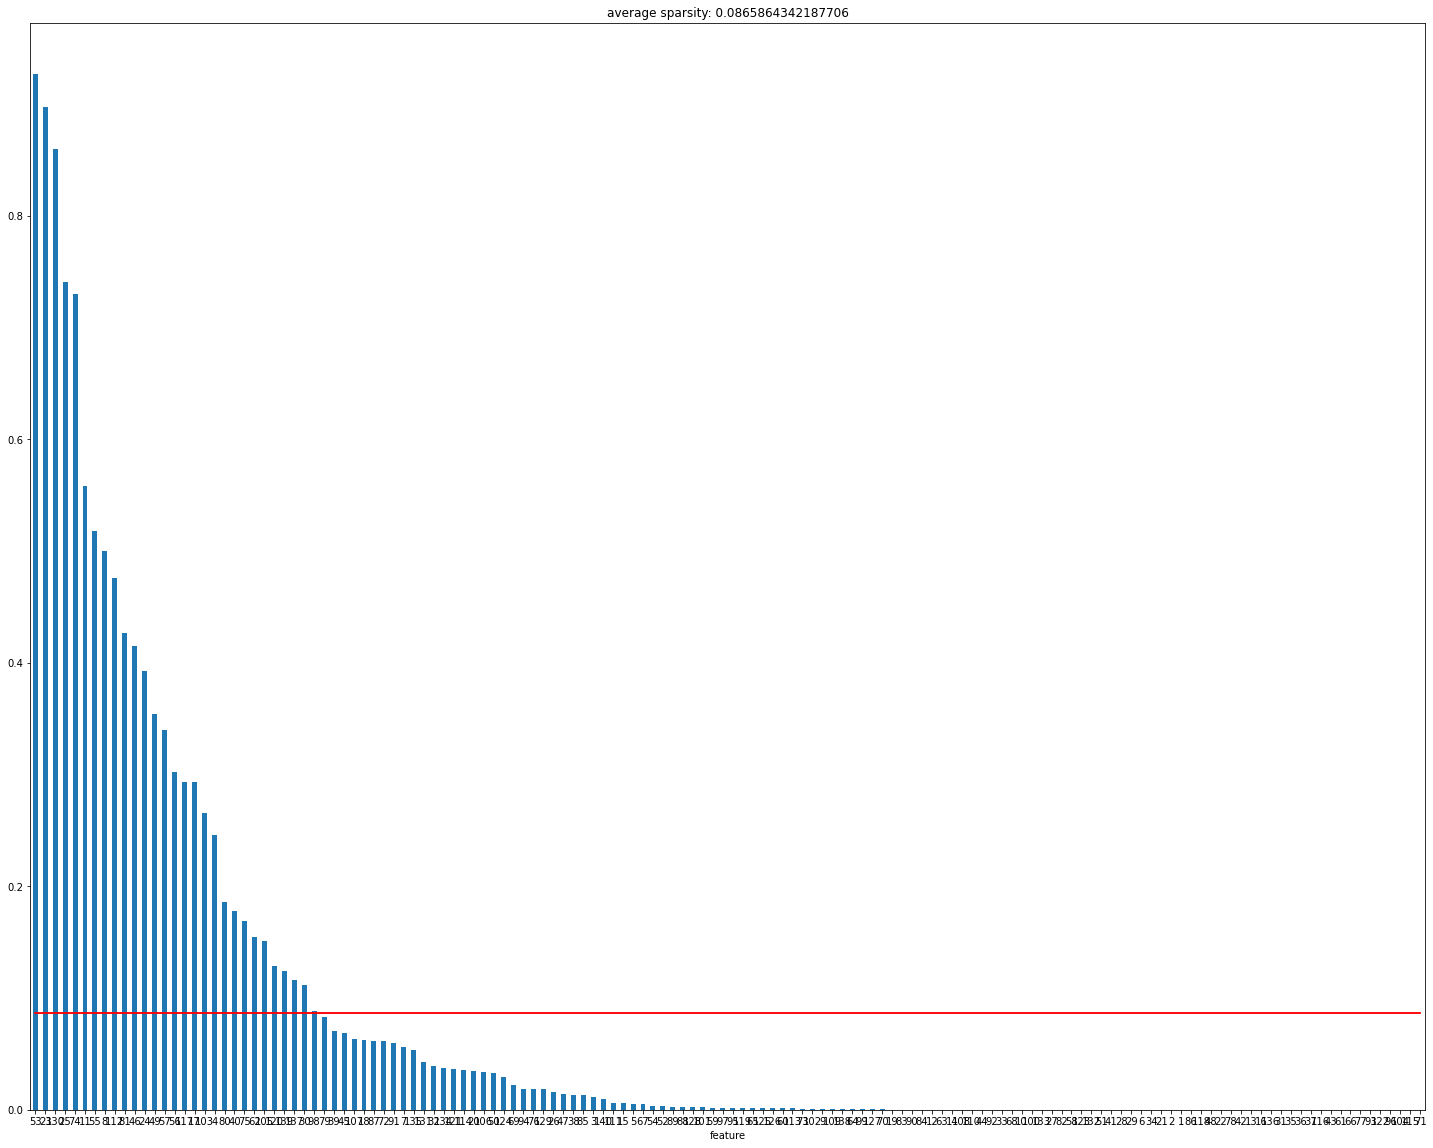

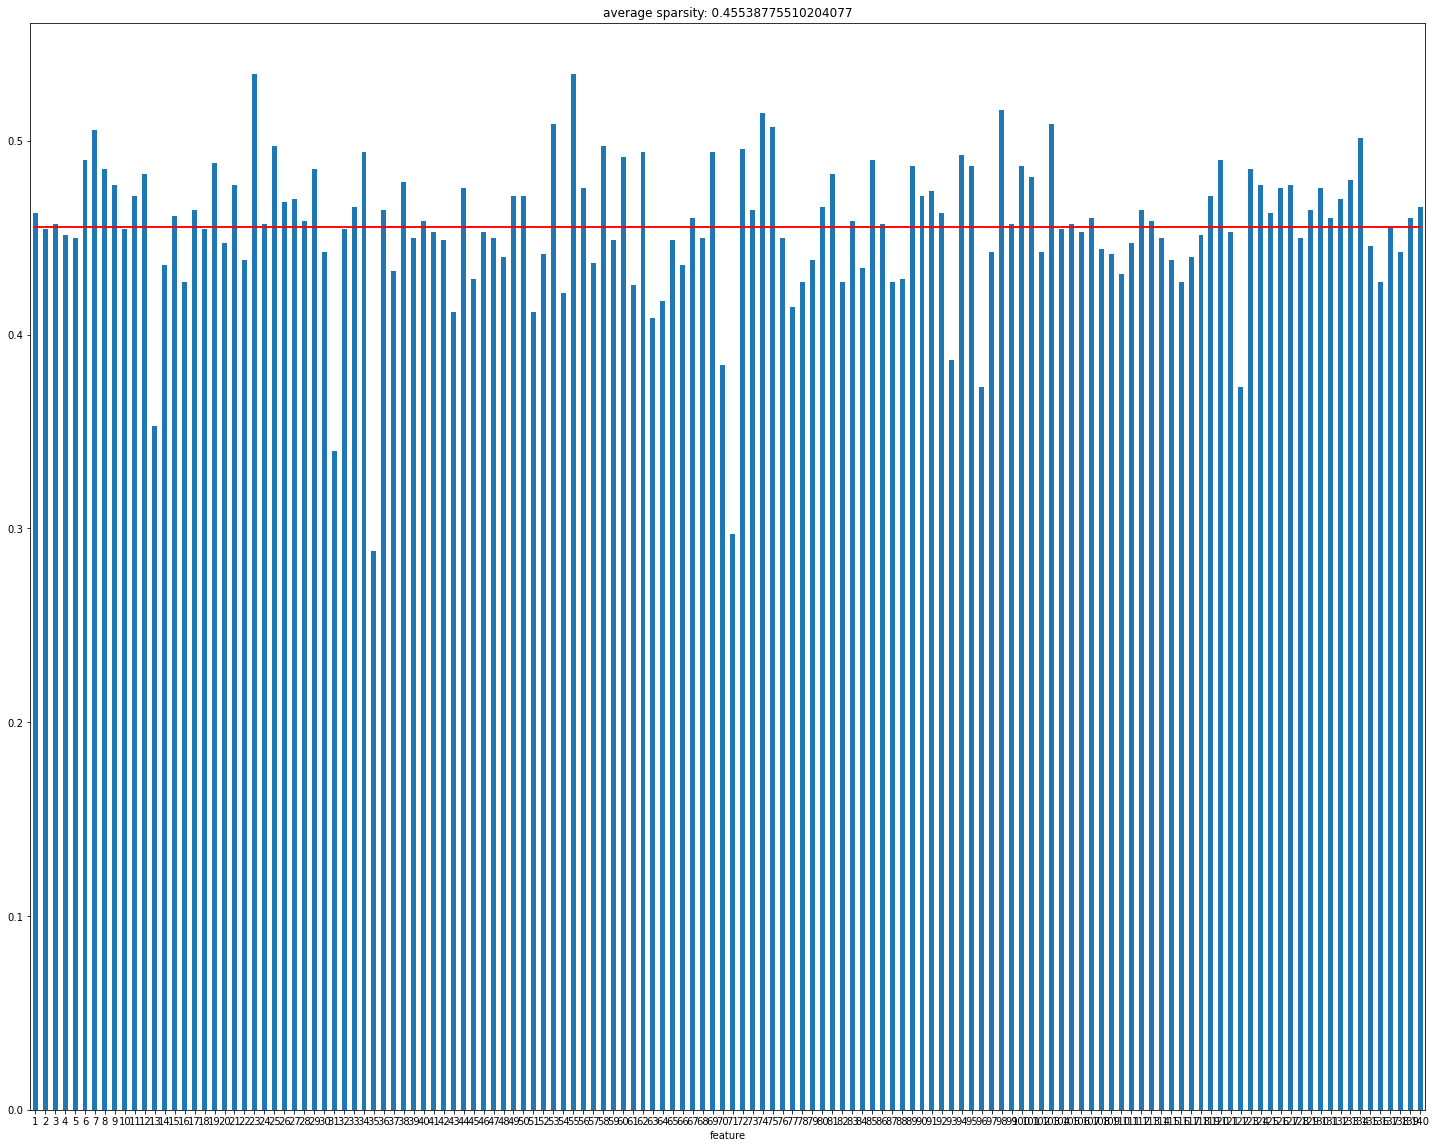

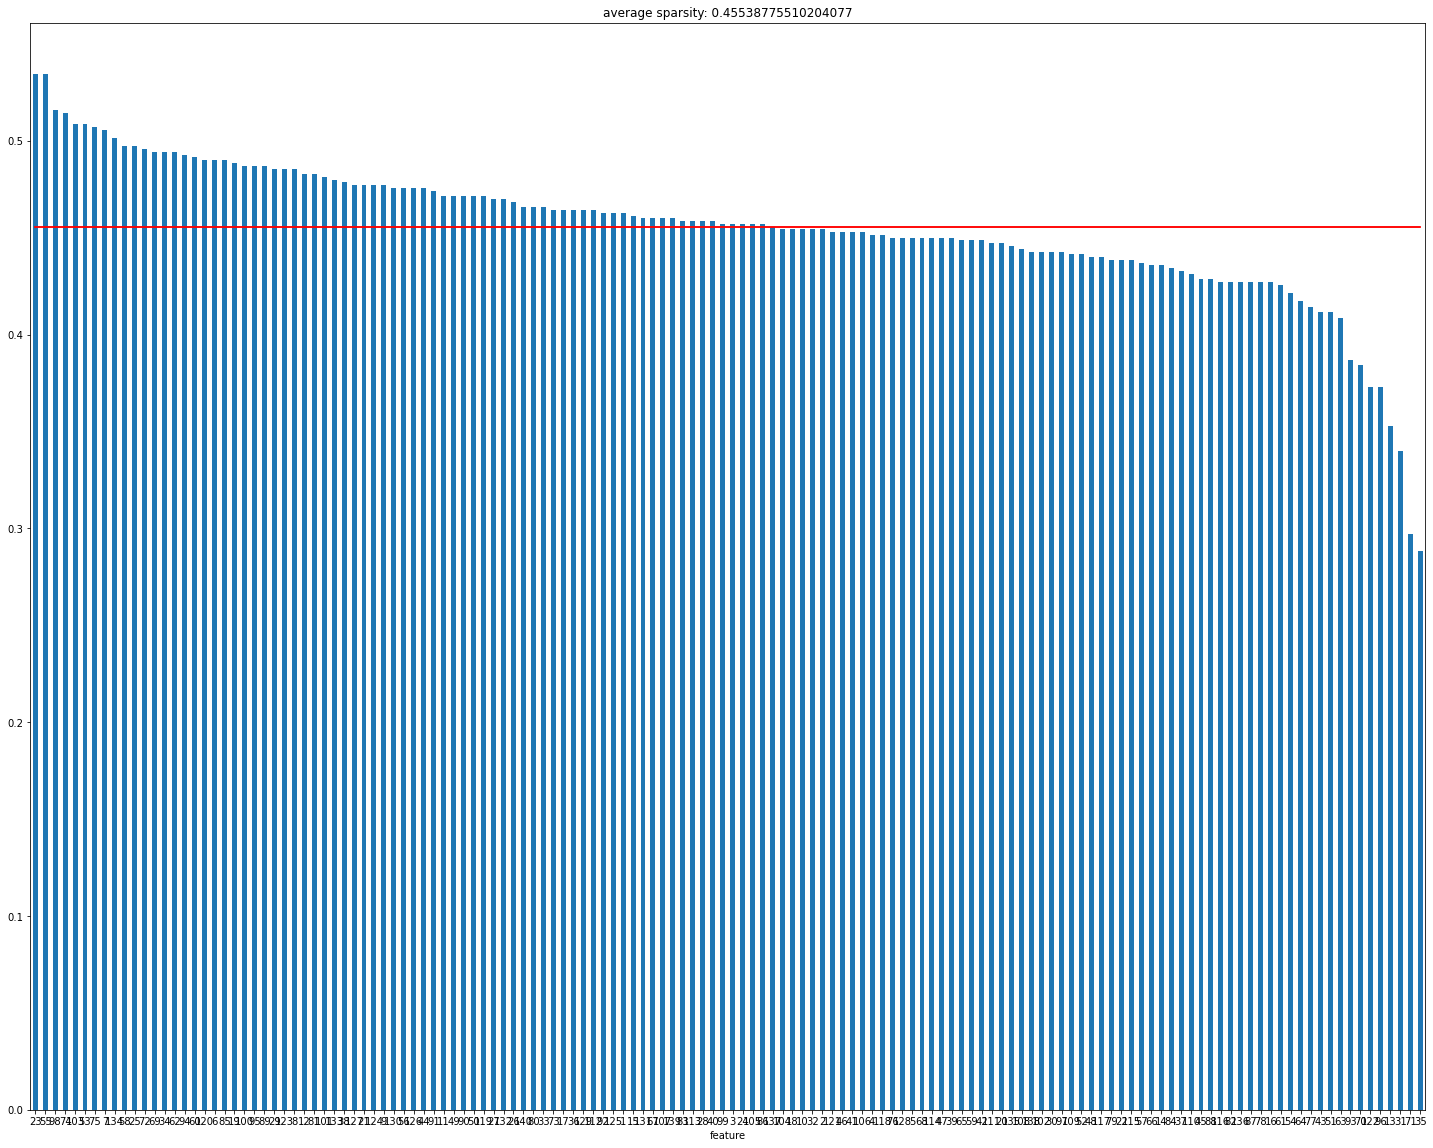

In [ ]:
features_overall_mean_batch_array = (lca.module.trace_weights > 0).cpu().numpy().sum(axis=(1, 2, 3)).squeeze()
v1_overall_mean_batch_array = (acts > 0).cpu().numpy().sum(axis=(0, 3, 4)).squeeze()

print(
    acts.shape,
    "\n",
    lca.module.trace_weights.shape,
    "\n",
    v1_overall_mean_batch_array.shape,
    "\n",
    features_overall_mean_batch_array,
    "\n",
    features_overall_mean_batch_array.shape,
    "\n",
    acts.shape[0] * acts.shape[-1] * acts.shape[-2],
)

bool_feat_freq_df = pd.DataFrame(columns=["feature", "frequency"])
bool_act_freq_df = pd.DataFrame(columns=["feature", "frequency"])

for n in range(len(v1_overall_mean_batch_array)):
    bool_act_freq_df.loc[n, "feature"] = n + 1
    bool_feat_freq_df.loc[n, "feature"] = n + 1
    bool_feat_freq_df.loc[n, "frequency"] = v1_overall_mean_batch_array[n] / (
        acts.shape[0] * acts.shape[-1] * acts.shape[-2]
    )
    bool_act_freq_df.loc[n, "frequency"] = features_overall_mean_batch_array[n] / (
        lca.module.trace_weights.shape[1] * lca.module.trace_weights.shape[2]
    )

print(bool_feat_freq_df.shape, bool_feat_freq_df["frequency"].max(), bool_feat_freq_df["frequency"].min())

mean_feat_sparsity = bool_feat_freq_df["frequency"].mean()
mean_feat_sparsity_df = bool_feat_freq_df * 0 + mean_feat_sparsity
ax1 = bool_feat_freq_df.plot.bar(x="feature", y="frequency", figsize=(25, 20), legend=False)
mean_feat_sparsity_df.plot(ax=ax1, color="r", title=f"average sparsity: {mean_feat_sparsity}", legend=False)

ax2 = bool_feat_freq_df.sort_values(by=["frequency"], ascending=False).plot.bar(
    x="feature", y="frequency", figsize=(25, 20), legend=False
)
mean_feat_sparsity_df.plot(ax=ax2, color="r", title=f"average sparsity: {mean_feat_sparsity}", legend=False)


mean_act_sparsity = bool_act_freq_df["frequency"].mean()
mean_act_sparsity_df = bool_act_freq_df * 0 + mean_act_sparsity
ax3 = bool_act_freq_df.plot.bar(x="feature", y="frequency", figsize=(25, 20), legend=False)
mean_act_sparsity_df.plot(ax=ax3, color="r", title=f"average sparsity: {mean_act_sparsity}", legend=False)

ax4 = bool_act_freq_df.sort_values(by=["frequency"], ascending=False).plot.bar(
    x="feature", y="frequency", figsize=(25, 20), legend=False
)
mean_act_sparsity_df.plot(ax=ax4, color="r", title=f"average sparsity: {mean_act_sparsity}", legend=False)

### Video Feature Dictionary

In [ ]:
T = lca.module.weights.shape[2]
grids = []
for t in range(T):
    grids.append(
        make_grid(
            lca.module.weights[:, :, t],
            int(math.sqrt(lca.module.weights.shape[0])),
            normalize=False,
            scale_each=False,
            pad_value=0.5,
        ).cpu()
    )
print(lca.module.weights.shape)
print(torch.stack(grids).shape)
final_grids = torch.stack(grids).permute(0, 2, 3, 1).cpu().numpy()
iio.mimwrite(f"../figures/test_link_dict.gif", final_grids, "gif")

Lossy conversion from float32 to uint8. Range [-0.38203978538513184, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.3219717741012573, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.3288765847682953, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.331413209438324, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.3276955783367157, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.31885063648223877, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.4176372289657593, 0.5046650171279907]. Convert image to uint8 prior to saving to suppress this warning.


torch.Size([140, 1, 7, 9, 9])
torch.Size([7, 3, 145, 123])


### Traces' Feature Grid

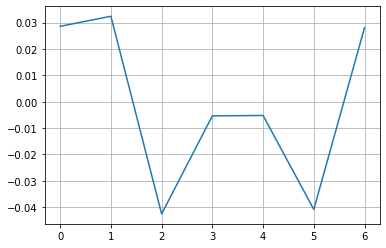

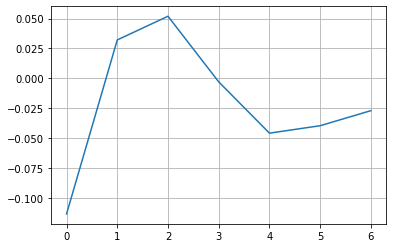

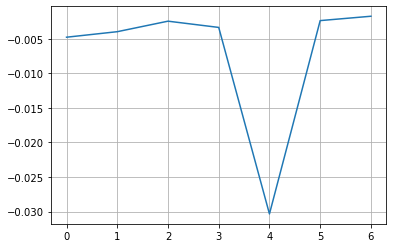

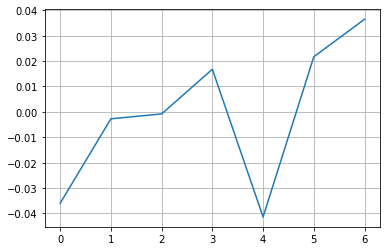

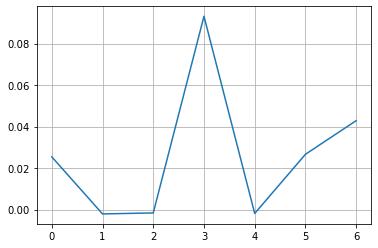

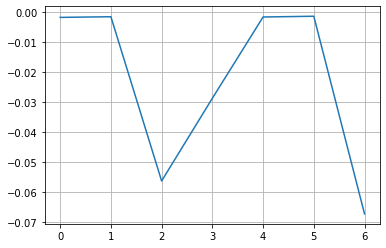

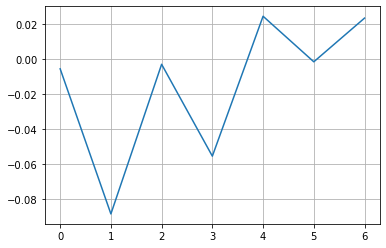

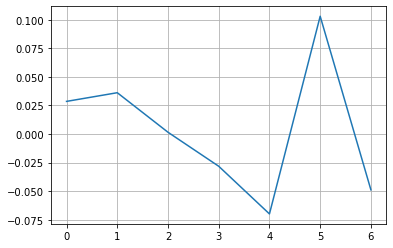

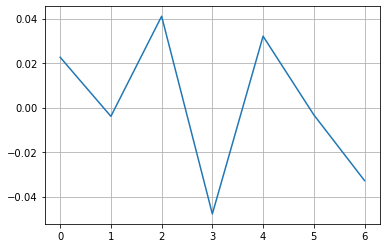

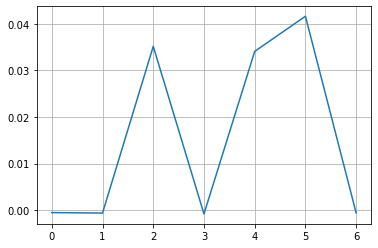

In [ ]:
exp_weight_grid = make_feature_grid(lca.module.trace_weights[:, 0].squeeze(-1).moveaxis(1, -1))
weight_grid = make_feature_grid(lca.module.trace_weights.squeeze(-1).squeeze(-1))
# arrange by neuron activation frequency (maximum to minimum)
for i in range(exp_weight_grid.shape[0] % PRINT_FREQ + 10):
    plt.plot(exp_weight_grid[i].cpu().numpy())
    # plt.plot(weight_grid[i].cpu().numpy())
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
for i in range(len(trace_recon_error)):
    fig, axs = plt.subplots(1, 3, figsize=(30, 20))
    axs[0].plot((trace_recon_error + trace_recon)[i, 0].cpu().numpy())
    axs[1].plot(trace_recon.cpu().numpy()[i, 0])
    axs[2].plot(trace_recon_error[i, 0].cpu().numpy())
    axs[0].set_title("Trace Input")
    axs[1].set_title("Trace Reconstruction")
    axs[2].set_title("Trace Reconstruction Error")

    for ax in axs:
        ax.set_ylim(-3, 3)
        ax.grid()

    plt.show()
    plt.close()

# LCA Validation

### Setup mouse V1 responses over time

In [20]:
mean_dff = pd.DataFrame()
max_dff = pd.DataFrame()
TOTAL_COLUMNS = 2
TOTAL_REPS = 1400
REPETITIONS = 10
exps_cells = []
column_exp = []
column_cell = []
dff_exps_movie3_list = []
complete_column_cell_exp_list = []

for column in dff_df.columns[7:]:
    complete_column_cell_exp_list.append(column)
    column_cell.append(column.split("_")[0])
    column_exp.append(column.split("_")[1])
new_column_exp = np.unique(column_exp)
print("Average cell count per experiment:")
print(
    len(np.unique(column_cell)) // len(np.unique(column_exp)),
    "=",
    len(np.unique(column_cell)),
    "//",
    len(np.unique(column_exp)),
)

for exp_index in range(15, 22):
    for cell_exp in complete_column_cell_exp_list:
        if str(cell_exp).endswith(new_column_exp[exp_index]):
            exps_cells.append(cell_exp)
print("total cells:", len(exps_cells))
dff_exps = dff_df[["frame", "repeat", "stimulus", "session_type", *exps_cells]]

for exp_cell in exps_cells:
    if dff_exps[dff_exps["stimulus"] == "natural_movie_three"][exp_cell].values.all() == False:
        dff_exp_movie_reps = torch.split(
            torch.tensor(
                dff_exps[["stimulus", exp_cell]]
                .where(dff_exps["stimulus"] == "natural_movie_three")
                .dropna()[exp_cell]
                .values
            ),
            NUM_INPUT_REP,
            0,
        )
        # dff_exp_cell = dff_exps[["stimulus", exp_cell]].where(dff_exps["stimulus"] == "natural_movie_three").dropna()
        for ind, dff_exp_sample in enumerate(dff_exp_movie_reps):
            # ind == 0 is only using the first repetition per cell
            # if ind == 0: dff_exps_movie3_list.append(dff_exp_sample)
            dff_exps_movie3_list.append(dff_exp_sample)
dff_exps_movie3 = torch.stack(dff_exps_movie3_list)
print(dff_exps_movie3.shape, len(dff_exps_movie3))

for cell_ind in range(0, TOTAL_REPS, REPETITIONS):
    grey_df = pd.concat(
        [
            pd.DataFrame(
                dff_exps_movie3[
                    cell_ind : cell_ind + REPETITIONS, : 2 * (dff_exps_movie3.shape[1] // SPLITTED_BATCHES - BATCH_SIZE)
                ].numpy()
            )
        ]
    )
    max_dff = pd.concat([max_dff, grey_df.max(axis=0).to_frame()], axis=1)
    mean_dff = pd.concat([mean_dff, grey_df.mean().to_frame()], axis=1)

Average cell count per experiment:
247 = 12380 // 50
total cells: 1220
torch.Size([5110, 3600]) 5110


In [42]:
max_dff_arr.shape, mean_dff_arr.shape

((140, 1080), (140, 1080))

In [40]:
max_dff_arr = np.array(max_dff.T)
# max_dff.plot(
#     subplots=True,
#     layout=(int(TOTAL_REPS // (TOTAL_COLUMNS * REPETITIONS)), TOTAL_COLUMNS),
#     figsize=(60, 30),
#     color="red",
# )

In [41]:
mean_dff_arr = np.array(mean_dff.T)
# mean_dff.plot(
#     subplots=True,
#     layout=(int(TOTAL_REPS // (TOTAL_COLUMNS * REPETITIONS)), TOTAL_COLUMNS),
#     figsize=(60, 30),
#     color="blue",
# )

### Setup LCA Activations over time (trace_act_usage)

In [18]:
trace_act_usage = torch.zeros(
    (
        2 * (len(splitted_wt[: len(splitted_wt) // SPLITTED_BATCHES]) * BATCH_SIZE - BATCH_SIZE),
        lca.module.trace_weights.shape[0],
        torch_wf.shape[-1] // 4,
        torch_wf.shape[-2],
    ),
    device="cpu",
)

for batch_ind in range(2 * len(splitted_wt) // SPLITTED_BATCHES - 2):
    trace_act_usage[batch_ind * BATCH_SIZE : batch_ind * BATCH_SIZE + BATCH_SIZE] = torch.load(
        f"../data/traces_act_usage/lca_chckpnt_{batch_ind}.pt"
    )

### Setup LCA Neurons' States over time (lca_neuron_states)

In [43]:
lca_neuron_states = torch.zeros(
    (
        2 * (len(splitted_wt[: len(splitted_wt) // SPLITTED_BATCHES]) * BATCH_SIZE - BATCH_SIZE),
        lca.module.trace_weights.shape[0],
        torch_wf.shape[-1] // 4,
        torch_wf.shape[-2],
    ),
    device="cpu",
)

for batch_ind in range(2 * len(splitted_wt) // SPLITTED_BATCHES - 2):
    lca_neuron_states[batch_ind * BATCH_SIZE : batch_ind * BATCH_SIZE + BATCH_SIZE] = torch.load(
        f"../data/traces_states/lca_chckpnt_{batch_ind}.pt"
    )

### Debugging mean_dff & trace_act_usage specific shapes

In [ ]:
mean_dff_arr = np.array(mean_dff)
# print(trace_act_usage.shape)
print(
    mean_dff_arr.flatten().max(),
    mean_dff_arr.flatten().min(),
    mean_dff_arr.flatten().mean(),
    mean_dff_arr.flatten().std(),
)

trace_act_usage.flatten().flatten().flatten().max(), trace_act_usage.flatten().flatten().flatten().min(), trace_act_usage.flatten().flatten().flatten().mean(), trace_act_usage.flatten().flatten().flatten().std()

In [ ]:
# print(trace_act_usage.max(-3, -2, -1).values)
# max_act_usage = trace_act_usage.max(-3, -2, -1)
# plt.scatter(range(140), max_act_usage.values.cpu().numpy())
print(trace_act_usage[:, feat_ind].shape, trace_act_usage.shape)
print(feat_ind, trace_act_usage[:, feat_ind].mean(0).shape, trace_act_usage[:, feat_ind].mean((-2, -1)).shape)
plt.plot(range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))), trace_act_usage[:, 1].mean((-2, -1)))

# fig, axs = plt.subplots(70, 2, figsize=(20, 30))
# for feat_ind in range(trace_act_usage.shape[1]):
#     max_act_usage = trace_act_usage[:, feat_ind].max((-2, -1))
#     if feat_ind < trace_act_usage.shape[1] // 2:
#         axs[feat_ind, 0].plot(
# 			range(360), max_act_usage.values.cpu().numpy())
#     else:
#         axs[feat_ind - (trace_act_usage.shape[1] // 2), 1].plot(
# 			range(360), max_act_usage.values.cpu().numpy())
# plt.show()

In [ ]:
reshaped_trace_act_usage = trace_act_usage.reshape(
    (len(trace_act_usage), trace_act_usage.shape[1], trace_act_usage.shape[-1] * trace_act_usage.shape[-2])
)

print(
    feat_ind,
    "\n",
    reshaped_trace_act_usage.shape,
    "\n",
    reshaped_trace_act_usage[:, feat_ind].shape,
    "\n",
    reshaped_trace_act_usage[:, feat_ind].max(-1).values,
    len(reshaped_trace_act_usage[:, feat_ind].max(-1).values),
)

### Scaling Methods

In [44]:
max_dff_arr /= max(map(max, np.absolute(max_dff_arr)))
np.argwhere(max_dff_arr == max(map(max, np.absolute(max_dff_arr)))), max(map(max, np.absolute(max_dff_arr)))

(array([[   1,   20],
        [  21,  179],
        [  30,  882],
        [  42,    2],
        [  44,  100],
        [  47,    0],
        [  52,  111],
        [  62,  858],
        [  67,   24],
        [  74,   63],
        [  76,  886],
        [  79,   39],
        [  82,  954],
        [  85, 1054],
        [  86,   77],
        [  93,  800],
        [  97,   39],
        [  98,  179],
        [ 113,   62],
        [ 120,  156],
        [ 126,  779],
        [ 129,  161],
        [ 130,  460],
        [ 134,  137],
        [ 137,  622]]),
 1.0)

In [45]:
mean_dff_arr /= max(map(max, np.absolute(mean_dff_arr)))
np.argwhere(mean_dff_arr == max(map(max, np.absolute(mean_dff_arr)))), max(map(max, np.absolute(mean_dff_arr)))

(array([[ 21, 174]]), 1.0)

In [46]:
lca_neuron_states /= lca_neuron_states.max()
torch.argwhere(lca_neuron_states == lca_neuron_states.max()), lca_neuron_states.max()

(tensor([[1079,   40,   22,  263]]), tensor(1.))

In [47]:
trace_act_usage /= trace_act_usage.max()
torch.argwhere(trace_act_usage == trace_act_usage.max()), trace_act_usage.max()

(tensor([[1079,   40,   22,  263]]), tensor(1.))

In [50]:
reshaped_trace_act_usage = trace_act_usage.reshape(
    (len(trace_act_usage), trace_act_usage.shape[1], trace_act_usage.shape[-1] * trace_act_usage.shape[-2])
)
reshaped_lca_neuron_states = lca_neuron_states.reshape(
    (len(lca_neuron_states), lca_neuron_states.shape[1], lca_neuron_states.shape[-1] * lca_neuron_states.shape[-2])
)

In [51]:
reshaped_trace_act_usage /= reshaped_trace_act_usage.max()
torch.argwhere(reshaped_trace_act_usage == reshaped_trace_act_usage.max()), reshaped_trace_act_usage.max()

reshaped_lca_neuron_states /= reshaped_lca_neuron_states.max()
torch.argwhere(reshaped_lca_neuron_states == reshaped_lca_neuron_states.max()), reshaped_lca_neuron_states.max()

(tensor([[1079,   40, 6951]]), tensor(1.))

### EYEBALL TESTING (INDIVIDUAL COMPARISONS)

##### MEAN POOLING

In [ ]:
mean_fig, mean_axs = plt.subplots(70, 4, figsize=(60, 80))

plt.setp(
    mean_axs,
    ylim=(
        trace_act_usage.mean((-2, -1)).min(0).values.min(0).values - 0.05,
        trace_act_usage.mean((-2, -1)).max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(trace_act_usage.shape[1]):
    # mean_act_usage = trace_act_usage[:, feat_ind].mean(-2, -1)
    if feat_ind < trace_act_usage.shape[1] // 2:
        mean_axs[feat_ind, 2].plot(mean_dff_arr[feat_ind], c="red")
        mean_axs[feat_ind, 0].plot(
            range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))), trace_act_usage[:, feat_ind].mean((-2, -1))
        )
    else:
        mean_axs[feat_ind - (trace_act_usage.shape[1] // 2), 3].plot(mean_dff_arr[feat_ind], c="red")
        mean_axs[feat_ind - (trace_act_usage.shape[1] // 2), 1].plot(
            range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))), trace_act_usage[:, feat_ind].mean((-2, -1))
        )
# plt.title("Individual Comparisons between Average-Pooled LCA Neuron Activations and Mice V1 Responses", fontsize=50)
# plt.xlabel("Frame", fontsize=50)
# plt.ylabel("Value", fontsize=50)
# plt.xticks(fontsize=50)
# plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()

##### MAX POOLING

In [ ]:
max_fig, max_axs = plt.subplots(70, 4, figsize=(60, 80))

reshaped_trace_act_usage = trace_act_usage.reshape(
    (len(trace_act_usage), trace_act_usage.shape[1], trace_act_usage.shape[-1] * trace_act_usage.shape[-2])
)

plt.setp(
    max_axs,
    ylim=(
        reshaped_trace_act_usage.max(-1).values.min(0).values.min(0).values - 0.05,
        reshaped_trace_act_usage.max(-1).values.max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(reshaped_trace_act_usage.shape[1]):
    if feat_ind < reshaped_trace_act_usage.shape[1] // 2:
        max_axs[feat_ind, 2].plot(mean_dff_arr[feat_ind], c="red")
        max_axs[feat_ind, 0].plot(
            range(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values)),
            reshaped_trace_act_usage[:, feat_ind].max(-1).values,
        )
    else:
        max_axs[feat_ind - (reshaped_trace_act_usage.shape[1] // 2), 3].plot(mean_dff_arr[feat_ind], c="red")
        max_axs[feat_ind - (reshaped_trace_act_usage.shape[1] // 2), 1].plot(
            range(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values)),
            reshaped_trace_act_usage[:, feat_ind].max(-1).values,
        )
# plt.title("Individual Comparisons between Max-Pooled LCA Neuron Activations and Mice V1 Responses", fontsize=50)
# plt.xlabel("Frame", fontsize=50)
# plt.ylabel("Value", fontsize=50)
# plt.xticks(fontsize=50)
# plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()

##### SUM POOLING

In [ ]:
sum_fig, sum_axs = plt.subplots(70, 4, figsize=(60, 80))

plt.setp(
    sum_axs,
    ylim=(
        trace_act_usage.sum((-2, -1)).min(0).values.min(0).values - 0.05,
        trace_act_usage.sum((-2, -1)).max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(trace_act_usage.shape[1]):
    # sum_act_usage = trace_act_usage[:, feat_ind].sum(-2, -1)
    if feat_ind < trace_act_usage.shape[1] // 2:
        sum_axs[feat_ind, 2].plot(mean_dff_arr[feat_ind], c="red")
        sum_axs[feat_ind, 0].plot(
            range(len(trace_act_usage[:, feat_ind].sum((-2, -1)))), trace_act_usage[:, feat_ind].sum((-2, -1))
        )
    else:
        sum_axs[feat_ind - (trace_act_usage.shape[1] // 2), 3].plot(mean_dff_arr[feat_ind], c="red")
        sum_axs[feat_ind - (trace_act_usage.shape[1] // 2), 1].plot(
            range(len(trace_act_usage[:, feat_ind].sum((-2, -1)))), trace_act_usage[:, feat_ind].sum((-2, -1))
        )
# plt.title("Individual Comparisons between Sum-Pooled LCA Neuron Activations and Mice V1 Responses", fontsize=50)
# plt.xlabel("Frame", fontsize=50)
# plt.ylabel("Value", fontsize=50)
# plt.xticks(fontsize=50)
# plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()

### EYEBALL TESTING (SINGLE FIGURE COMPARISON)

##### MEAN POOLING

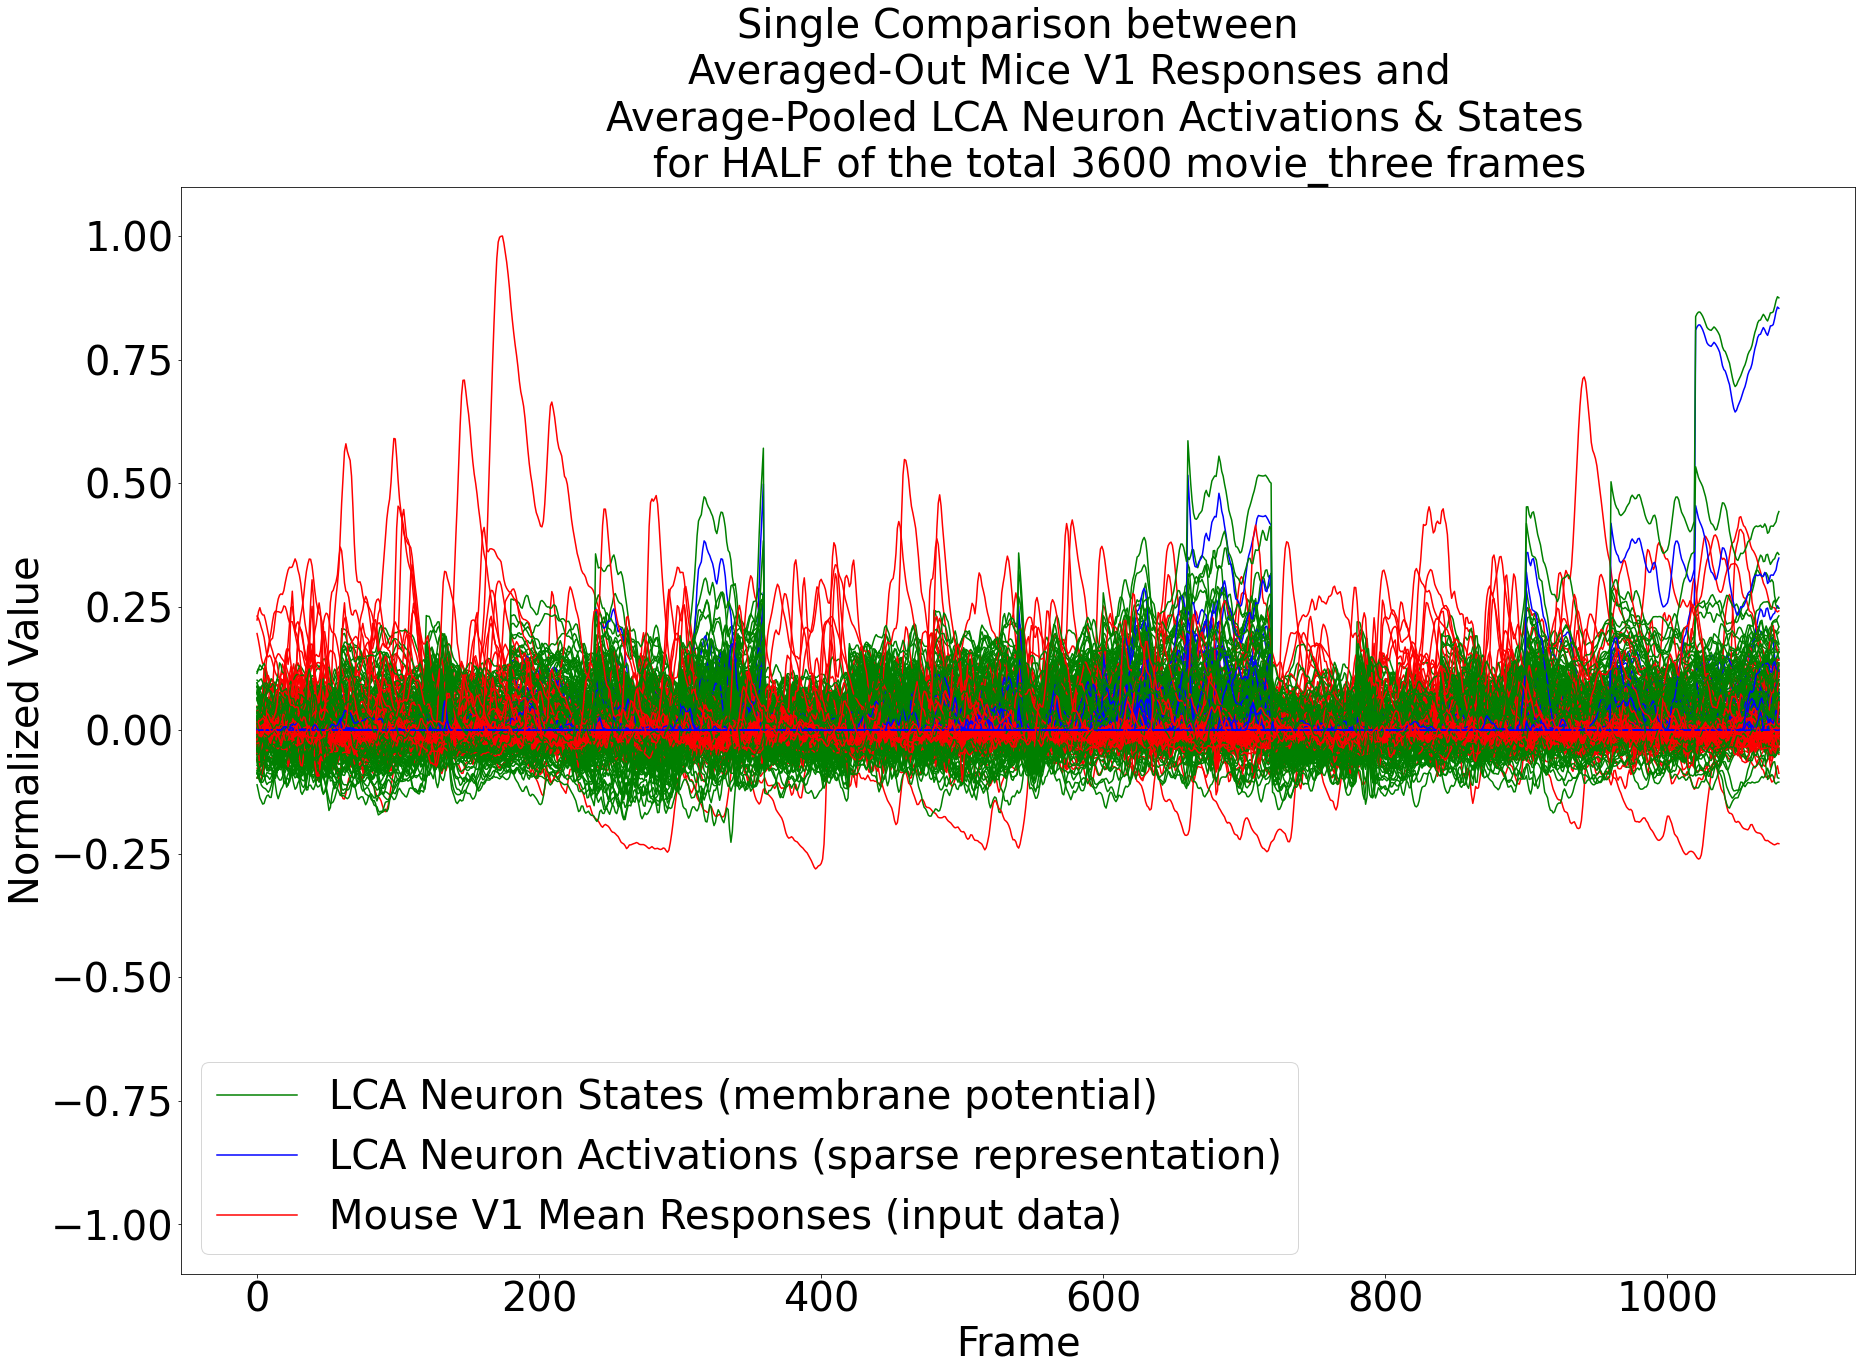

In [48]:
mean_fig, mean_axs = plt.subplots(1, 1, figsize=(30, 20))

if int(trace_act_usage.max()) == int(max(map(max, np.absolute(mean_dff_arr)))):
    plt.setp(mean_axs, ylim=(-1.1, 1.1))
elif int(trace_act_usage.max()) > int(max(map(max, np.absolute(mean_dff_arr)))):
    plt.setp(mean_axs, ylim=(-1.1, trace_act_usage.max()))
else:
    plt.setp(mean_axs, ylim=(-1.1, max(map(max, np.absolute(mean_dff_arr)))))


for feat_ind in range(trace_act_usage.shape[1]):
    # if np.absolute(mean_dff_arr[feat_ind]).max(0) != 1:
    #     mean_dff_arr[feat_ind] /= np.absolute(mean_dff_arr[feat_ind]).max(0)
    # if torch.max(torch.abs(trace_act_usage[:, feat_ind].mean((-2, -1))),axis=0).values.max(0).values > 1:
    #     trace_act_usage[:, feat_ind] /= torch.max(torch.abs(trace_act_usage[:, feat_ind].mean((-2, -1))),axis=0).values

    if feat_ind == 0:
        mean_axs.plot(
            range(len(lca_neuron_states[:, feat_ind].mean((-2, -1)))),
            lca_neuron_states[:, feat_ind].mean((-2, -1)),
            c="green",
            label="LCA Neuron States (membrane potential)",
        )
        mean_axs.plot(
            range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))),
            trace_act_usage[:, feat_ind].mean((-2, -1)),
            c="blue",
            label="LCA Neuron Activations (sparse representation)",
        )
        mean_axs.plot(mean_dff_arr[feat_ind], c="red", label="Mouse V1 Mean Responses (input data)")
    else:
        mean_axs.plot(
            range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))),
            trace_act_usage[:, feat_ind].mean((-2, -1)),
            c="blue",
        )
        mean_axs.plot(
            range(len(lca_neuron_states[:, feat_ind].mean((-2, -1)))),
            lca_neuron_states[:, feat_ind].mean((-2, -1)),
            c="green",
        )
        mean_axs.plot(mean_dff_arr[feat_ind], c="red")

plt.ylabel("Normalized Value", fontsize=40)
plt.xlabel("Frame", fontsize=40)
plt.legend(prop={"size": 40})
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title(
    f"Single Comparison between\n\
        Averaged-Out Mice V1 Responses and\n\
            Average-Pooled LCA Neuron Activations & States\n\
                for HALF of the total {len(movie)} movie_three frames",
    fontsize=40,
)
plt.show()

##### MAX POOLING

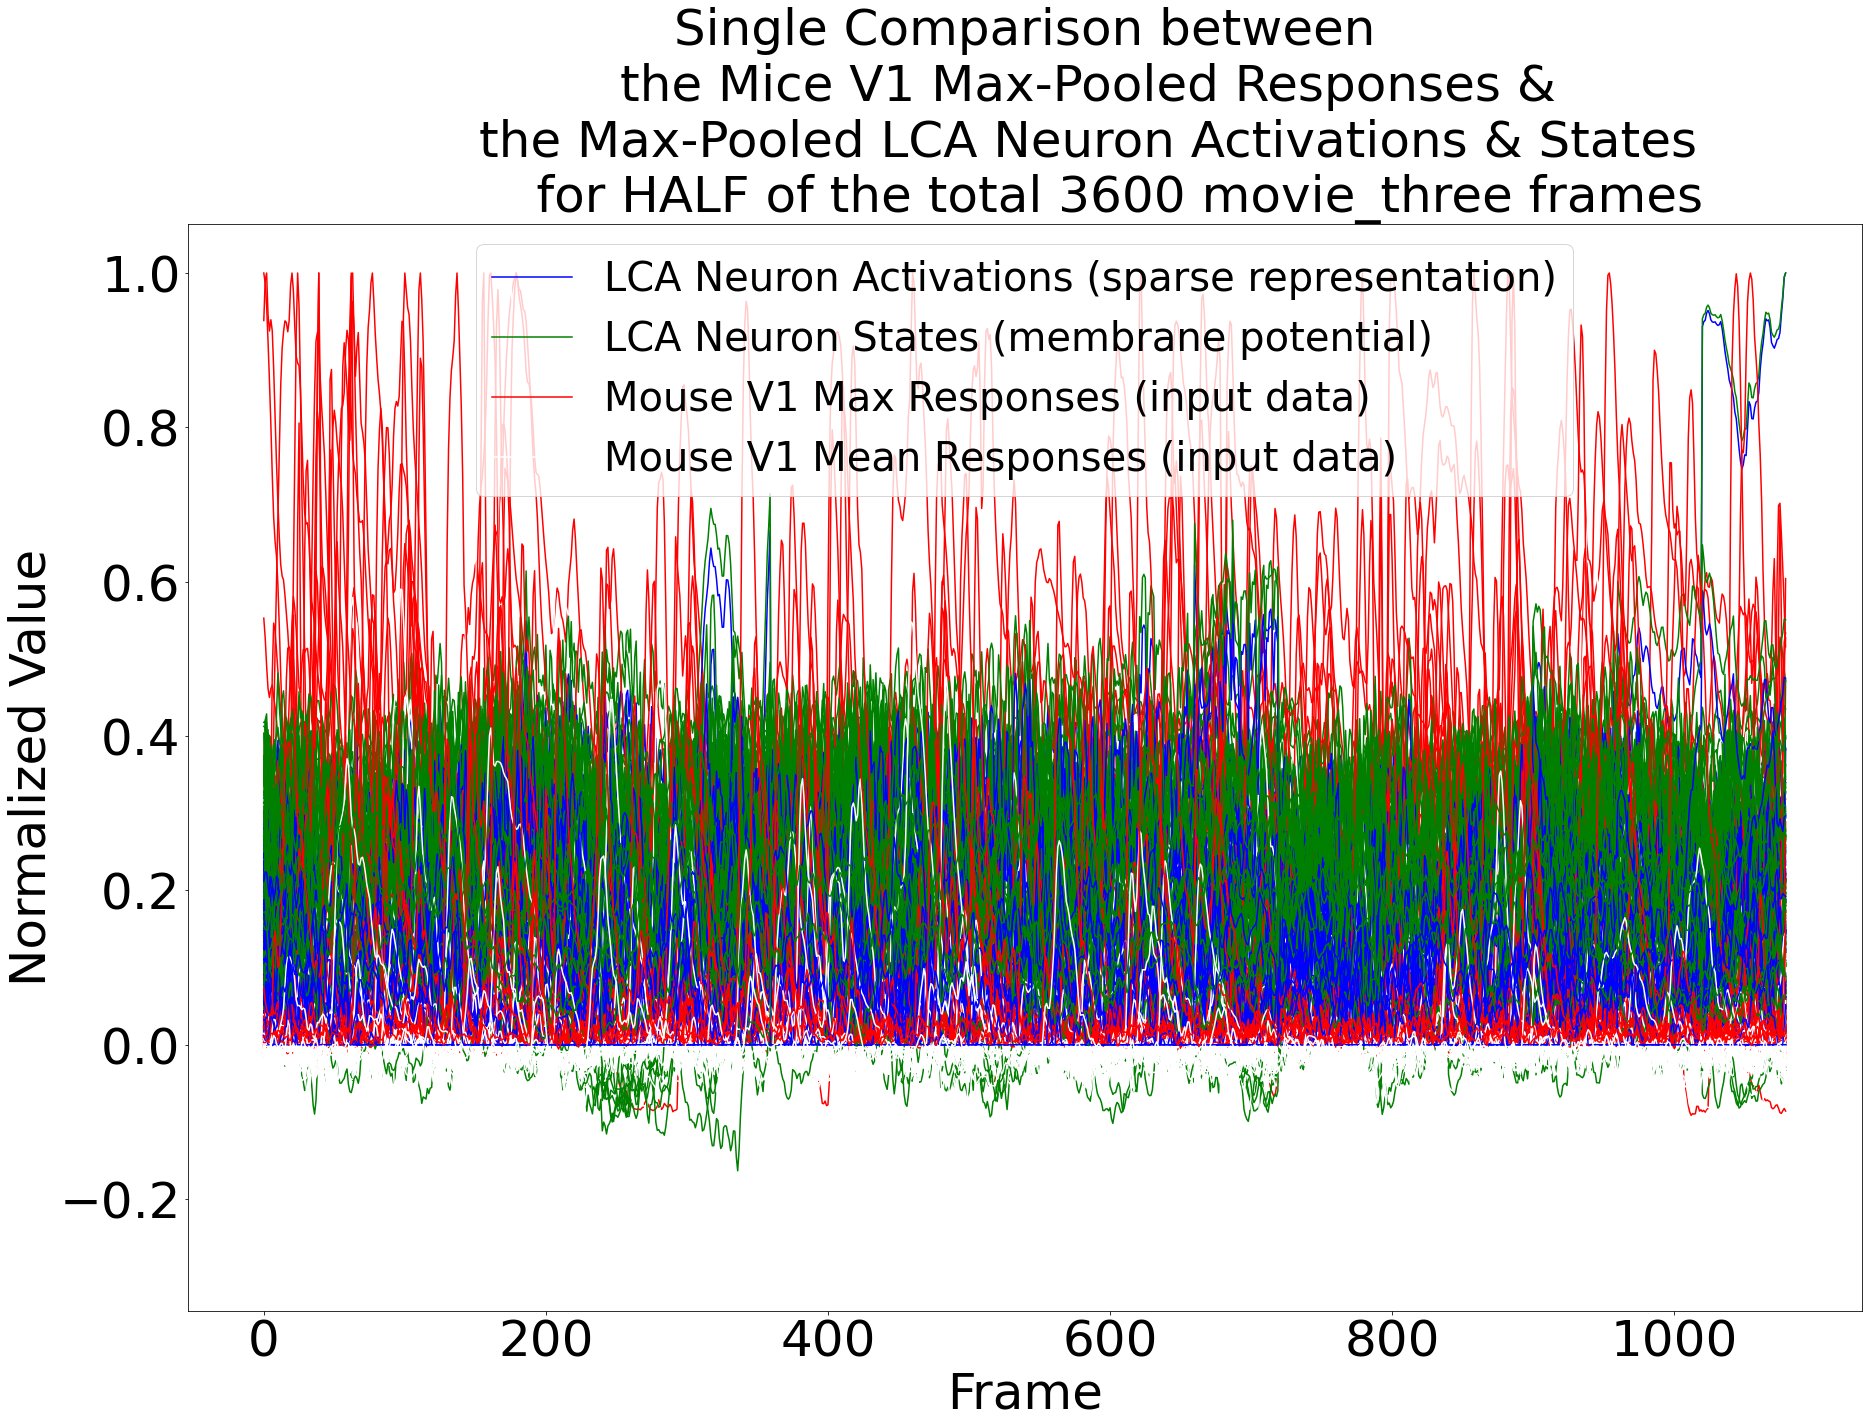

In [52]:
# reshaped_trace_act_usage = trace_act_usage.reshape(
#     (len(trace_act_usage), trace_act_usage.shape[1], trace_act_usage.shape[-1] * trace_act_usage.shape[-2])
# )

# reshaped_trace_act_usage /= reshaped_trace_act_usage.max()

if int(trace_act_usage.max()) == int(max(map(max, np.absolute(mean_dff_arr)))):
    plt.setp(mean_axs, ylim=(-1.1, 1.1))
elif int(trace_act_usage.max()) > int(max(map(max, np.absolute(mean_dff_arr)))):
    plt.setp(mean_axs, ylim=(-1.1, trace_act_usage.max()))
else:
    plt.setp(mean_axs, ylim=(-1.1, max(map(max, np.absolute(mean_dff_arr)))))

max_fig, max_axs = plt.subplots(1, 1, figsize=(30, 20))
# plt.setp(max_axs, ylim=(-0.5,1.1))

for feat_ind in range(reshaped_trace_act_usage.shape[1]):
    if feat_ind == 0:
        max_axs.plot(
            range(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values)),
            reshaped_trace_act_usage[:, feat_ind].max(-1).values,
            c="blue",
            label="LCA Neuron Activations (sparse representation)",
        )
        max_axs.plot(
            range(len(reshaped_lca_neuron_states[:, feat_ind].max(-1).values)),
            reshaped_lca_neuron_states[:, feat_ind].max(-1).values,
            c="green",
            label="LCA Neuron States (membrane potential)",
        )
        max_axs.plot(max_dff_arr[feat_ind], c="red", label="Mouse V1 Max Responses (input data)")
        max_axs.plot(mean_dff_arr[feat_ind], c="white", label="Mouse V1 Mean Responses (input data)")
        # print(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values), reshaped_trace_act_usage[:, feat_ind].shape, reshaped_trace_act_usage.shape)
    else:
        max_axs.plot(
            range(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values)),
            reshaped_trace_act_usage[:, feat_ind].max(-1).values,
            c="blue",
        )
        max_axs.plot(
            range(len(reshaped_lca_neuron_states[:, feat_ind].max(-1).values)),
            reshaped_lca_neuron_states[:, feat_ind].max(-1).values,
            c="green",
        )
        max_axs.plot(max_dff_arr[feat_ind], c="red")
        max_axs.plot(mean_dff_arr[feat_ind], c="white")


plt.ylabel("Normalized Value", fontsize=50)
plt.xlabel("Frame", fontsize=50)
plt.legend(prop={"size": 40})
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.title(
    f"Single Comparison between\n\
        the Mice V1 Max-Pooled Responses &\n\
        the Max-Pooled LCA Neuron Activations & States\n\
            for HALF of the total {len(movie)} movie_three frames",
    fontsize=50,
)
plt.show()

##### SUM POOLING

In [ ]:
sum_fig, sum_axs = plt.subplots(1, 1, figsize=(30, 20))

plt.setp(
    sum_axs,
    ylim=(
        trace_act_usage.sum((-2, -1)).min(0).values.min(0).values - 0.05,
        trace_act_usage.sum((-2, -1)).max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(trace_act_usage.shape[1]):
    if feat_ind == 0:
        sum_axs.plot(
            range(len(trace_act_usage[:, feat_ind].sum((-2, -1)))),
            trace_act_usage[:, feat_ind].sum((-2, -1)),
            c="blue",
            label="LCA Neuron Activations",
        )
        sum_axs.plot(mean_dff_arr[feat_ind], c="red", label="Mouse V1 Responses")
    else:
        sum_axs.plot(
            range(len(trace_act_usage[:, feat_ind].sum((-2, -1)))),
            trace_act_usage[:, feat_ind].sum((-2, -1)),
            c="blue",
        )
        sum_axs.plot(mean_dff_arr[feat_ind], c="red")

plt.title("Single Comparison between Sum-Pooled LCA Neuron Activations and Mice V1 Responses", fontsize=50)
plt.xlabel("Frame", fontsize=50)
plt.ylabel("Value", fontsize=50)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.tight_layout()
plt.legend()
plt.show()

### Debugging for Post-processing

##### LCA Neuron Activations as reconstructed movie feature

In [ ]:
%matplotlib inline

# print(len(acts_list))
# for act_ind, act_sample in enumerate (acts_list):
# 	if act_ind == 0: print(act_sample.shape, act_sample)

new_acts_list = []
for acts_sample in acts_list:
    acts_sample = acts_sample.cpu()
    new_acts_list.append(acts_sample.cpu())

t_acts = torch.stack(new_acts_list).to("cpu")
t_acts = torch.reshape(
    t_acts.squeeze(), (t_acts.shape[0] * t_acts.shape[1], t_acts.shape[2], t_acts.shape[-2], t_acts.shape[-1])
)
print(t_acts.shape)
for i in range(t_acts.shape[1]):
    if not os.path.exists(f"../reports/images_acts/cell{i+1}lca/"):
        os.makedirs(f"../reports/images_acts/cell{i+1}lca/")
    act_imgs = []

    for j in range(t_acts.shape[0]):
        save_image(t_acts[j, i, :, :], f"../reports/images_acts/cell{i+1}lca/img{j}.png")

    for act_path in sorted(glob.glob(f"../reports/images_acts/cell{i+1}lca/*.png")):
        # print(img_path, iio.imread(img_path).shape)
        act_imgs.append(iio.imread(act_path))

    iio.mimsave(f"../reports/movies_acts/movie_lca_cell_{i+1}.gif", act_imgs)
plt.show()

##### Non-capped LCA Neuron Activations

In [ ]:
%matplotlib inline

new_trace_recon_list = []
for trace_recon_sample in trace_recon_list:
    new_trace_recon_list.append(trace_recon_sample.detach())

t_trace_recons = torch.stack(new_trace_recon_list)
t_trace_recons = torch.reshape(
    t_trace_recons,
    (t_trace_recons.shape[0] * t_trace_recons.shape[1], t_trace_recons.shape[-2], t_trace_recons.shape[-1]),
)
print(t_trace_recons.shape)

fig, axs = plt.subplots(50, 2, figsize=(20, 30))
for i in range(t_trace_recons.shape[-2]):
    plot_trace_recon_list = []
    for j in range(t_trace_recons.shape[0]):
        if j == 0:
            for k in range(t_trace_recons.shape[-1]):
                plot_trace_recon_list.append(t_trace_recons[j, i, k].cpu().numpy())
        else:
            plot_trace_recon_list.append(t_trace_recons[j, i, -1].cpu().numpy())
    t_plot_trace_recons = np.array(plot_trace_recon_list)
    if i < t_trace_recons.shape[-2] // 2:
        axs[i, 0].plot(t_plot_trace_recons)
    else:
        axs[i - (t_trace_recons.shape[-2] // 2), 1].plot(t_plot_trace_recons)
plt.show()

# Correlations Scores

2
2
4
4
6
8
10
6
3 5


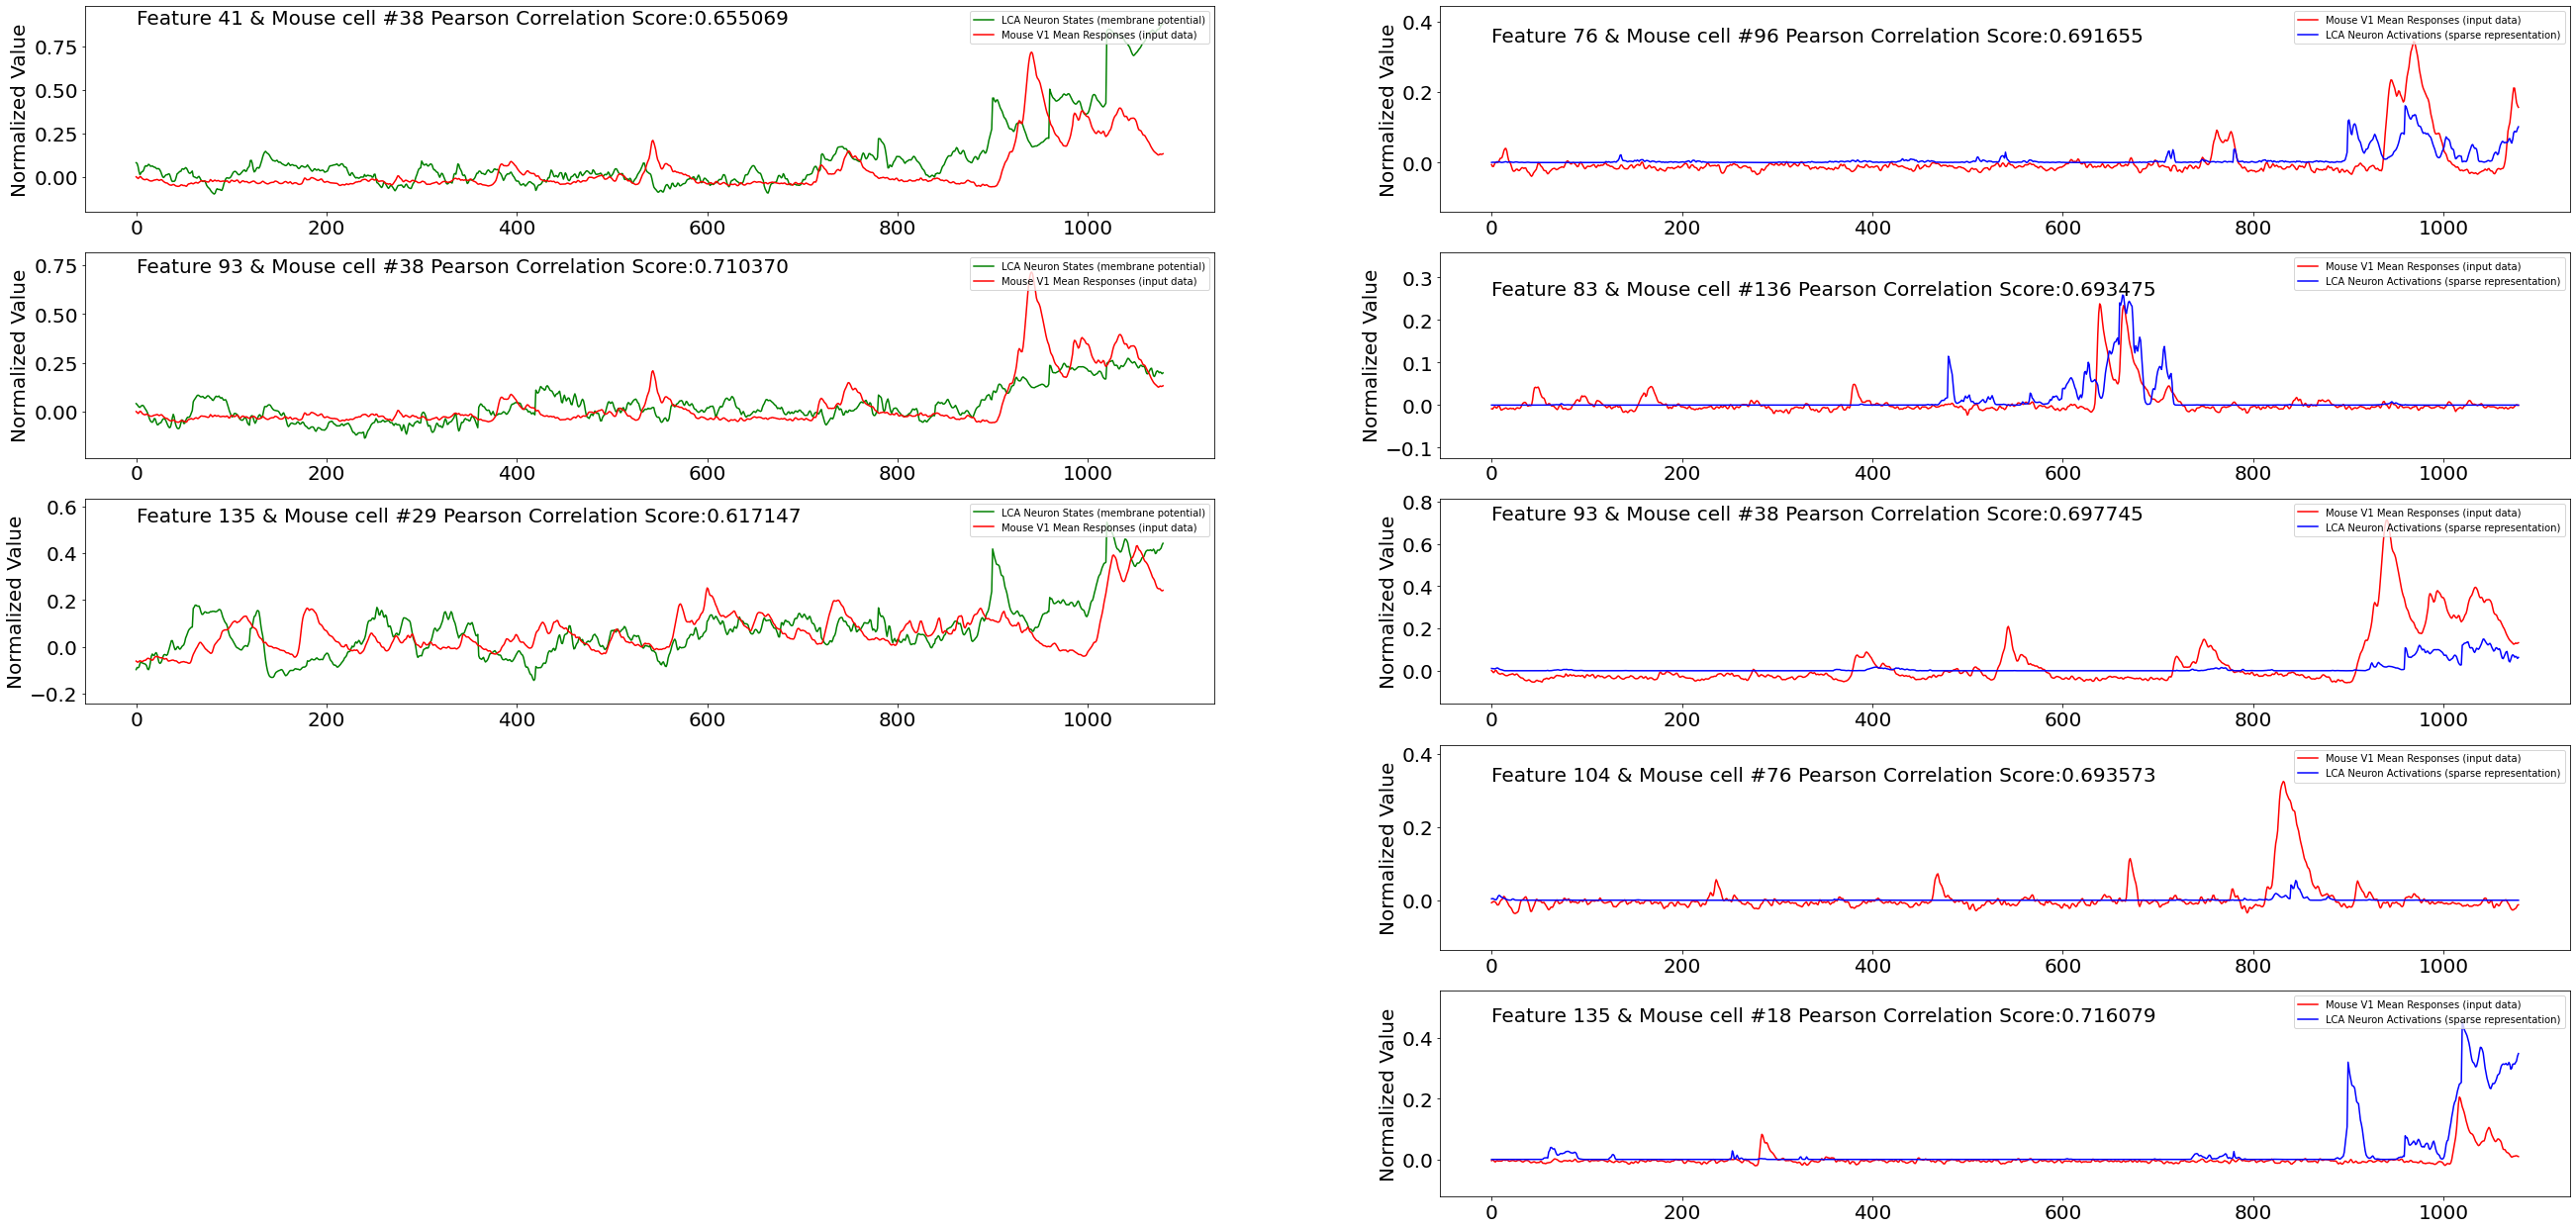

In [64]:
import scipy.stats as ss

# corr_fig, corr_axs = plt.subplots(10, 2, sharex=True, sharey=True, figsize=(30, 50))
states_counter = 0
acts_counter = 0
feat_corr = []
plt.close()

for feat_ind in range(lca.module.trace_weights.shape[0]):
    a_corr_scores_per_lca_feat = []
    s_corr_scores_per_lca_feat = []
    mean_trace_act_usage_feat = trace_act_usage[:, feat_ind].mean((-2, -1))
    mean_lca_neuron_states_feat = lca_neuron_states[:, feat_ind].mean((-2, -1))

    for mean_dff_arr_feat_index, mean_dff_arr_feature in enumerate(mean_dff_arr):
        stat_a, _ = ss.pearsonr(mean_trace_act_usage_feat, mean_dff_arr_feature)
        stat_s, _ = ss.pearsonr(mean_lca_neuron_states_feat, mean_dff_arr_feature)
        # print(ss.pearsonr(mean_lca_neuron_states_feat, mean_dff_arr_feature)[0])
        a_corr_scores_per_lca_feat.append(ss.pearsonr(mean_trace_act_usage_feat, mean_dff_arr_feature)[0])
        s_corr_scores_per_lca_feat.append(ss.pearsonr(mean_lca_neuron_states_feat, mean_dff_arr_feature)[0])

        if stat_s >= 0.6:
            states_counter += 2
            if int(states_counter) <= 20:
                print(states_counter)
                corr_axs = plt.subplot(10, 2, states_counter - 1)
                corr_axs.plot(
                    range(len(mean_lca_neuron_states_feat)),
                    mean_lca_neuron_states_feat,
                    c="green",
                    label="LCA Neuron States (membrane potential)",
                )
                corr_axs.plot(
                    range(len(mean_dff_arr_feature)),
                    mean_dff_arr_feature,
                    c="red",
                    label="Mouse V1 Mean Responses (input data)",
                )
                # print('state corr: ', feat_ind, mean_dff_arr_feat_index, stat_s)
                if mean_dff_arr_feature.max() >= mean_lca_neuron_states_feat.max():
                    if mean_dff_arr_feature.min() <= mean_lca_neuron_states_feat.min():
                        corr_axs.set_ylim([mean_dff_arr_feature.min() - 0.1, mean_dff_arr_feature.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_s:6f}",
                            xy=(0, mean_dff_arr_feature.max()),
                            size=20,
                        )
                    else:
                        corr_axs.set_ylim([mean_lca_neuron_states_feat.min() - 0.1, mean_dff_arr_feature.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_s:6f}",
                            xy=(0, mean_dff_arr_feature.max()),
                            size=20,
                        )
                else:
                    if mean_dff_arr_feature.min() <= mean_lca_neuron_states_feat.min():
                        corr_axs.set_ylim([mean_dff_arr_feature.min() - 0.1, mean_lca_neuron_states_feat.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_s:6f}",
                            xy=(0, mean_lca_neuron_states_feat.max()),
                            size=20,
                        )
                    else:
                        corr_axs.set_ylim(
                            [mean_lca_neuron_states_feat.min() - 0.1, mean_lca_neuron_states_feat.max() + 0.1]
                        )
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_s:6f}",
                            xy=(0, mean_lca_neuron_states_feat.max()),
                            size=20,
                        )
                corr_axs.set_ylabel("Normalized Value", fontsize=20)
                corr_axs.yaxis.set_tick_params(labelsize=20)
                corr_axs.xaxis.set_tick_params(labelsize=20)
                corr_axs.legend(loc='upper right', prop={"size": 10})

        if stat_a >= 0.6935:
            acts_counter += 2
            if int(acts_counter) <= 20:
                print(acts_counter)
                corr_axs = plt.subplot(10, 2, acts_counter)
                corr_axs.plot(
                    range(len(mean_dff_arr_feature)),
                    mean_dff_arr_feature,
                    c="red",
                    label="Mouse V1 Mean Responses (input data)",
                )
                corr_axs.plot(
                    range(len(mean_trace_act_usage_feat)),
                    mean_trace_act_usage_feat,
                    c="blue",
                    label="LCA Neuron Activations (sparse representation)",
                )
                # print('acts corr:', feat_ind, mean_dff_arr_feat_index, stat_a)
                if mean_dff_arr_feature.max() >= mean_trace_act_usage_feat.max():
                    if mean_dff_arr_feature.min() <= mean_trace_act_usage_feat.min():
                        corr_axs.set_ylim([mean_dff_arr_feature.min() - 0.1, mean_dff_arr_feature.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_a:6f}",
                            xy=(0, mean_dff_arr_feature.max()),
                            size=20,
                        )
                    else:
                        corr_axs.set_ylim([mean_trace_act_usage_feat.min() - 0.1, mean_dff_arr_feature.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_a:6f}",
                            xy=(0, mean_dff_arr_feature.max()),
                            size=20,
                        )
                else:
                    if mean_dff_arr_feature.min() <= mean_trace_act_usage_feat.min():
                        corr_axs.set_ylim([mean_dff_arr_feature.min() - 0.1, mean_trace_act_usage_feat.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_a:6f}",
                            xy=(0, mean_trace_act_usage_feat.max()),
                            size=20,
                        )
                    else:
                        corr_axs.set_ylim(
                            [mean_trace_act_usage_feat.min() - 0.1, mean_trace_act_usage_feat.max() + 0.1]
                        )
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_a:6f}",
                            xy=(0, mean_trace_act_usage_feat.max()),
                            size=20,
                        )
                corr_axs.set_ylabel("Normalized Value", fontsize=20)
                corr_axs.xaxis.set_tick_params(labelsize=20)
                corr_axs.yaxis.set_tick_params(labelsize=20)
                corr_axs.legend(loc='upper right', prop={"size": 10})

    feat_corr.append((s_corr_scores_per_lca_feat, a_corr_scores_per_lca_feat))

print(states_counter // 2, acts_counter // 2)
plt.gcf().set_size_inches(45, 45)
plt.show()

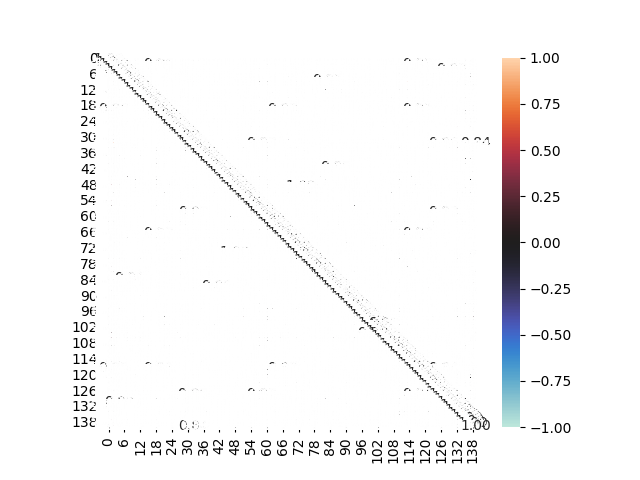

{'corr':           0         1         2         3         4         5         6    \
 0    1.000000 -0.080781 -0.028436 -0.020200 -0.009566 -0.038087 -0.046107   
 1   -0.080781  1.000000 -0.069289 -0.067181  0.050731  0.089619 -0.253876   
 2   -0.028436 -0.069289  1.000000 -0.006100 -0.016795 -0.021753 -0.083510   
 3   -0.020200 -0.067181 -0.006100  1.000000  0.093930 -0.021739  0.162839   
 4   -0.009566  0.050731 -0.016795  0.093930  1.000000 -0.024215 -0.056608   
 ..        ...       ...       ...       ...       ...       ...       ...   
 135 -0.019377 -0.012922 -0.010299 -0.011521 -0.012565 -0.016367  0.129740   
 136 -0.016644 -0.041204  0.695012 -0.008459 -0.010293 -0.013638 -0.050956   
 137 -0.028358  0.360281 -0.019612 -0.018260 -0.015981  0.147718 -0.086224   
 138 -0.070973 -0.124955 -0.033817 -0.039241 -0.044926 -0.057371  0.205848   
 139  0.180528 -0.113808  0.343321  0.429902  0.030806 -0.001846  0.138216   
 
           7         8         9    ...       130     

In [ ]:
# plt.close()
# associations(pd.DataFrame(trace_act_usage.mean((-2, -1)).cpu().numpy()))